In [1]:
!pip3 install tensorflow
!pip3 install kagglehub

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from tensorflow import keras
from keras import layers
import time
import gc

In [3]:
file_path = os.path.join("wre.us.txt")
df = pd.read_csv(file_path)

# Extraer encabezados
header = df.columns.tolist()
price = df["Close"].to_numpy()             
raw_data = df.iloc[:, 1:].to_numpy() 


# Punto 1
## Parsing Data



In [4]:

price_high = df["High"].to_numpy()
price_low = df["Low"].to_numpy()
price = (price_high + price_low) / 2

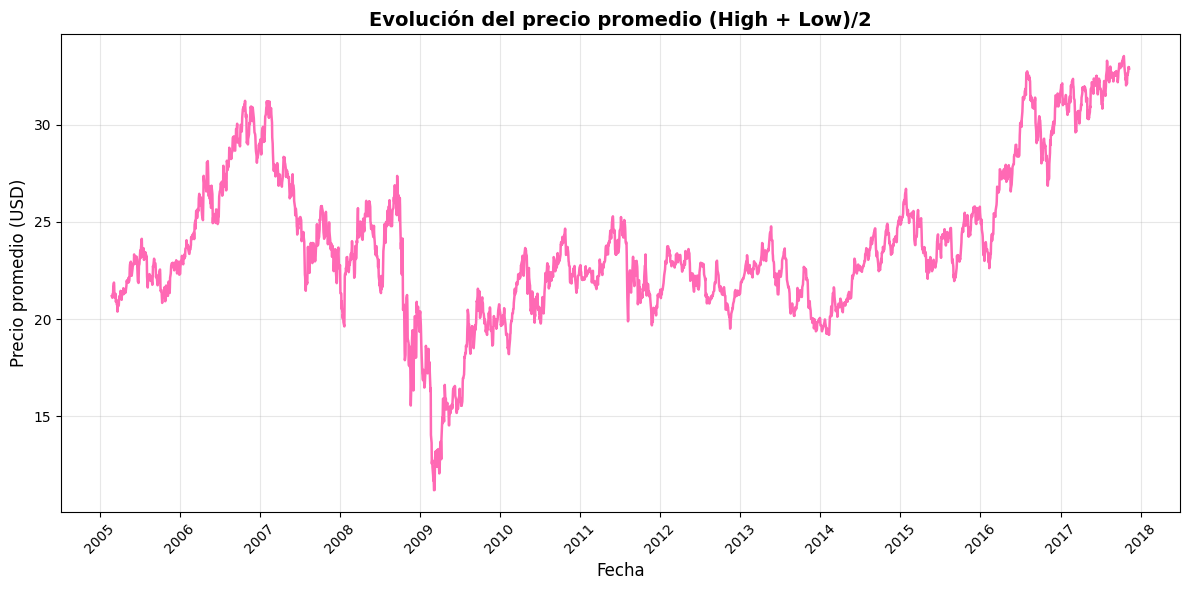

In [5]:


# Convertir la columna 'Date' a formato de fecha
df["Date"] = pd.to_datetime(df["Date"])

plt.figure(figsize=(12,6))
plt.plot(df["Date"], price, color='hotpink', linewidth=1.8)

# Título y etiquetas
plt.title("Evolución del precio promedio (High + Low)/2", fontsize=14, weight='bold')
plt.xlabel("Fecha", fontsize=12)
plt.ylabel("Precio promedio (USD)", fontsize=12)

# Formato del eje X para fechas
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))       
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 

# Rotar etiquetas y ajustar estilo
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Normalization

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 1600
num_val_samples: 800
num_test_samples: 801


In [7]:
print("¿Hay NaN en raw_data?:", np.isnan(raw_data).any())
print("¿Hay inf en raw_data?:", np.isinf(raw_data).any())
std = raw_data[:num_train_samples].std(axis=0)
print("Mínimo std:", np.min(std))

¿Hay NaN en raw_data?: False
¿Hay inf en raw_data?: False
Mínimo std: 0.0


In [8]:

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)

# Verificar columnas con std = 0
constant_cols = np.where(std == 0)[0]
column_names = df.columns[1:]
print("Columnas constantes:", column_names[constant_cols])
print("Número de columnas constantes:", len(constant_cols))

std[std == 0] = 1 
raw_data /= std


Columnas constantes: Index(['OpenInt'], dtype='object')
Número de columnas constantes: 1


### Clase Redes

In [14]:


class ModelBuilder:
    def __init__(self, raw_data, price, sequence_length):
        self.raw_data = raw_data
        self.price = price
        self.sequence_length = sequence_length
        self.models = {}
        self.histories = {}
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

 
    def create_datasets(self, delay, batch_size, sampling_rate, num_train_samples, num_val_samples):
        self.train_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=0,
            end_index=num_train_samples
        )

        self.val_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples,
            end_index=num_train_samples + num_val_samples
        )

        self.test_dataset = keras.utils.timeseries_dataset_from_array(
            data=self.raw_data[:-delay],
            targets=self.price[delay:],
            sequence_length=self.sequence_length,
            sampling_rate=sampling_rate,
            shuffle=False,
            batch_size=batch_size,
            start_index=num_train_samples + num_val_samples
        )

        return self.train_dataset, self.val_dataset, self.test_dataset

   
    def create_LSTM_model(self, num_neurons, epochs, dropout_rate=0.0, use_recurrent_dropout=False, name_model="LSTM"):
        inputs = keras.Input(shape=(self.sequence_length, self.raw_data.shape[-1]))
        x = layers.LSTM(num_neurons, recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
        outputs = layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)


        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset)

        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history

 
    def create_GRU_model(self, num_neurons, epochs, dropout_rate=0.0, use_recurrent_dropout=False, name_model="GRU"):
        inputs = keras.Input(shape=(self.sequence_length, self.raw_data.shape[-1]))
        x = layers.GRU(num_neurons, recurrent_dropout=dropout_rate if use_recurrent_dropout else 0)(inputs)
        outputs = layers.Dense(1)(x)
        model = keras.Model(inputs, outputs)

        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset)

        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history

  
    def create_stacked_GRU(self, num_l1, num_l2, epochs, name_model="Stacked_GRU"):
        num_features = self.raw_data.shape[-1]
        output_dim = 1

        model = tf.keras.Sequential([
            tf.keras.layers.GRU(num_l1, return_sequences=True, input_shape=(self.sequence_length, num_features)),
            tf.keras.layers.GRU(num_l2, return_sequences=False),
            tf.keras.layers.Dense(output_dim, activation='linear')
        ])

        model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
        history = model.fit(self.train_dataset, epochs=epochs, validation_data=self.val_dataset)

        print(f"Test MAE: {model.evaluate(self.test_dataset)[1]:.2f}")
        self.models[name_model] = model
        self.histories[name_model] = history
        return model, history
    
    
    def graph_history(self,history):
        loss = history.history["mae"]
        val_loss = history.history["val_mae"]
        epochs = range(1, len(loss) + 1)
        plt.figure()
        plt.plot(epochs, loss, "lightpink", label="Training MAE")
        plt.plot(epochs, val_loss, "purple", label="Validation MAE")
        plt.title("Training and validation MAE (LSTM)")
        plt.legend()
        plt.show()
        
        
    
    def graph_prediction(self,y_true, predictions):
        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(y_true[20:40], label='True Values', color='pink')
        plt.plot(predictions[20:40], label='Predicted Values', color='purple')
        plt.title('LSTM Predictions vs True Values')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()


 
    # def predict(self, model):
        
    #     if model is None:
    #         raise ValueError(f"Modelo {model} no existe.")
        
    #     y_true = np.concatenate([y for x, y in self.test_dataset], axis=0)
    #     predictions = model.predict(self.test_dataset)
    #     return y_true, predictions
    
    
    
    def predict(self, model):
        if model is None:
            raise ValueError(f"Modelo {model} no existe.")
        
        # Obtener y_true y predictions
        y_true = np.concatenate([y for x, y in self.test_dataset], axis=0)
        predictions = model.predict(self.test_dataset)
        
        # CORRECCIÓN CRÍTICA: Asegurar que ambos sean 1D
        y_true = y_true.flatten()  # Convierte (n, 1) a (n,)
        predictions = predictions.flatten()  # Convierte (n, 1) a (n,)
        
        # erificación de longitud
        if len(y_true) != len(predictions):
            min_len = min(len(y_true), len(predictions))
            y_true = y_true[:min_len]
            predictions = predictions[:min_len]
            print(f" Ajustadas longitudes: {min_len} muestras")
        
        return y_true, predictions

    
    # def verify_mae(self, model):
    #     """Verifica que el MAE de Keras coincida con nuestro cálculo manual"""
    #     y_true, predictions = self.predict(model)
        
    #     # MAE manual
    #     manual_mae = np.mean(np.abs(y_true - predictions))
        
    #     # MAE de Keras (el que ya estás mostrando)
    #     keras_mae = model.evaluate(self.test_dataset, verbose=0)[1]
        
    #     print(f"VERIFICACIÓN MAE:")
    #     print(f"   Keras MAE: {keras_mae:.6f}")
    #     print(f"   Manual MAE: {manual_mae:.6f}")
    #     print(f"   Diferencia: {abs(keras_mae - manual_mae):.6f}")
        
    #     # Deben ser casi iguales (diferencia < 0.001)
    #     if abs(keras_mae - manual_mae) < 0.001:
    #         print("MAE calculado CORRECTAMENTE")
    #     else:
    #         print("PROBLEMA con el cálculo de MAE")
        
    #     return manual_mae
   
    def calculate_metrics(self, y_true, predictions):
        
        
        mae = np.mean(np.abs(y_true - predictions))
        mse = np.mean((y_true - predictions)**2)
        rmse = np.sqrt(mse)
        
        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}") 
        print(f"RMSE: {rmse:.4f}")
        
        return mae, mse, rmse



# Pruebas

In [15]:
builder = ModelBuilder(raw_data, price, sequence_length=30)

# Crear datasets
builder.create_datasets(delay=1, batch_size=32, sampling_rate=1,
                        num_train_samples=num_train_samples,
                        num_val_samples=num_val_samples)


(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [16]:
builder2 = ModelBuilder(raw_data, price, sequence_length=60)

# Crear datasets
builder2.create_datasets(delay=1, batch_size=64, sampling_rate=1,
                        num_train_samples=num_train_samples,
                        num_val_samples=num_val_samples)


(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [17]:
builder3 = ModelBuilder(raw_data, price, sequence_length=90)

# Crear datasets
builder3.create_datasets(delay=1, batch_size=128, sampling_rate=1,
                        num_train_samples=num_train_samples,
                        num_val_samples=num_val_samples)


(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

# Punto 2

In [18]:
model_lstm1_1, hist_lstm1_1 = builder.create_LSTM_model(num_neurons=64, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM1_1_64")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 371.4870 - mae: 18.6401 - val_loss: 159.0241 - val_mae: 12.5535
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 154.2662 - mae: 11.7202 - val_loss: 80.9380 - val_mae: 8.9151
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 87.5576 - mae: 8.5193 - val_loss: 36.0207 - val_mae: 5.8787
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 46.1737 - mae: 5.9283 - val_loss: 11.9842 - val_mae: 3.2439
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 22.9382 - mae: 3.8749 - val_loss: 2.3737 - val_mae: 1.2583
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11.6067 - mae: 2.5179 - val_loss: 1.6110 - val_mae: 1.0308
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.7358 - mae: 2.0225 - val_loss: 0.9412 - val_mae: 0.8118
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.7833 - mae: 1.7410 - val_loss: 0.8744 - val_mae: 0.7650
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1

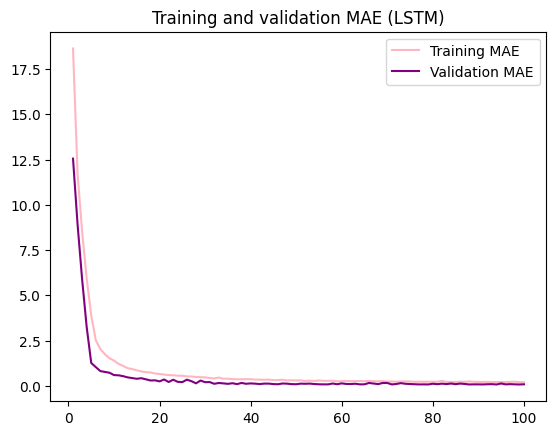

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MAE: 0.3946
MSE: 0.6167
RMSE: 0.7853


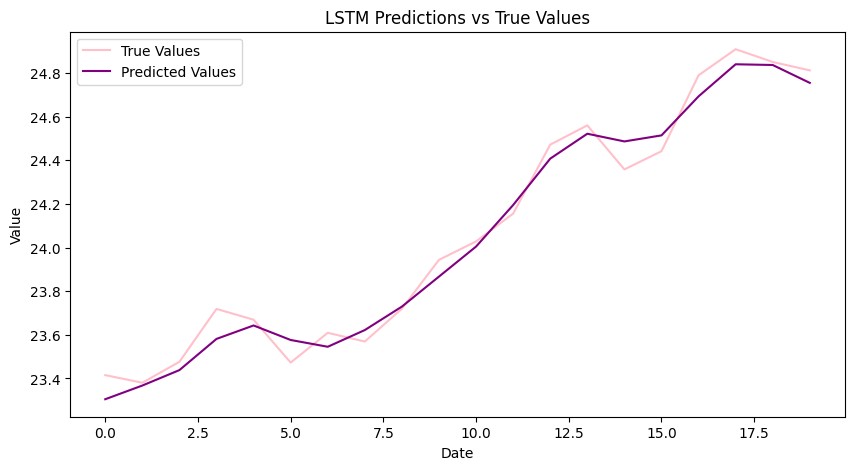

In [19]:
builder.graph_history(hist_lstm1_1)
y_true, predictions = builder.predict(model_lstm1_1)
builder.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder.graph_prediction(y_true, predictions)

In [20]:
model_lstm1_2, hist_lstm1_2 = builder.create_LSTM_model(num_neurons=128, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM1_2_128")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 145.3472 - mae: 10.3137 - val_loss: 17.0151 - val_mae: 3.9441
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 22.2713 - mae: 3.7787 - val_loss: 1.4830 - val_mae: 1.0182
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.4175 - mae: 2.1321 - val_loss: 3.4106 - val_mae: 1.6091
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.0504 - mae: 1.6835 - val_loss: 1.2650 - val_mae: 0.9313
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.7229 - mae: 1.4153 - val_loss: 0.7599 - val_mae: 0.7150
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7814 - mae: 1.1966 - val_loss: 0.6384 - val_mae: 0.6659
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.6974 - mae: 1.1277 - val_loss: 0.4581 - val_mae: 0.5443
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9301 - mae: 0.9777 - val_loss: 0.3811 - val_mae: 0.4928
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

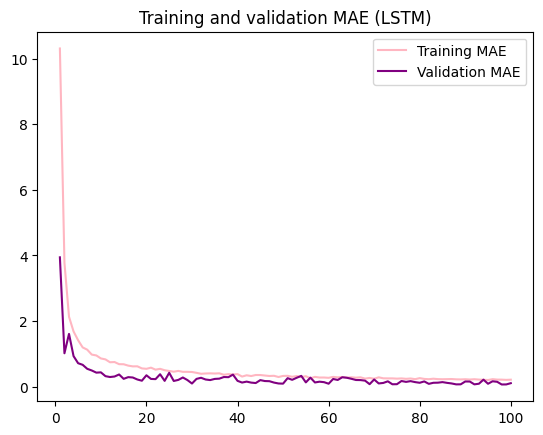

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MAE: 0.6568
MSE: 1.9295
RMSE: 1.3891


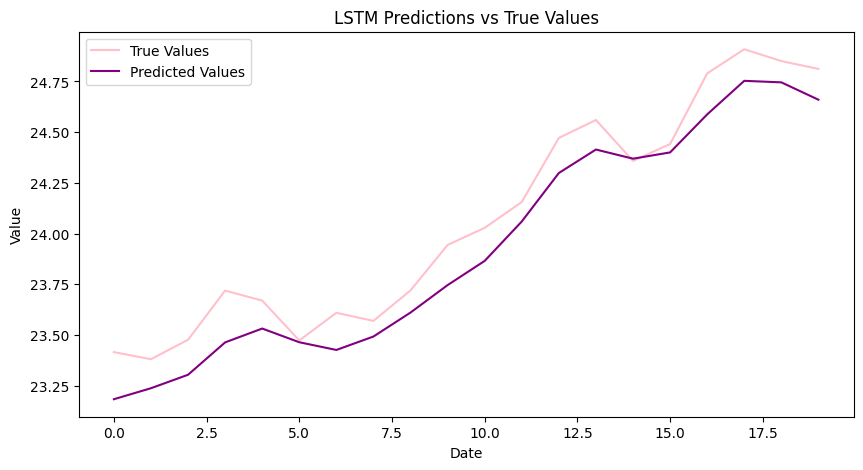

In [21]:
builder.graph_history(hist_lstm1_2)
y_true, predictions = builder.predict(model_lstm1_2)
builder.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder.graph_prediction(y_true, predictions)

In [22]:
model_lstm1_3, hist_lstm1_3 = builder.create_LSTM_model(num_neurons=32, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM1_3_32")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 485.4244 - mae: 21.7461 - val_loss: 316.2831 - val_mae: 17.7487
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 315.8114 - mae: 17.3992 - val_loss: 203.1533 - val_mae: 14.2021
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 216.4685 - mae: 14.2081 - val_loss: 145.5601 - val_mae: 12.0043
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 162.9048 - mae: 12.1539 - val_loss: 106.3387 - val_mae: 10.2409
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 124.5105 - mae: 10.4672 - val_loss: 75.9976 - val_mae: 8.6333
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 93.9478 - mae: 8.9479 - val_loss: 51.9874 - val_mae: 7.1079
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 69.4021 - mae: 7.5295 - val_loss: 33.3719 - val_mae: 5.6486
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 50.1563 - mae: 6.2733 - val_loss: 19.6793 - val_mae: 4.2678
Epoch 9/100
50/50 ━━━━━━━━━━━

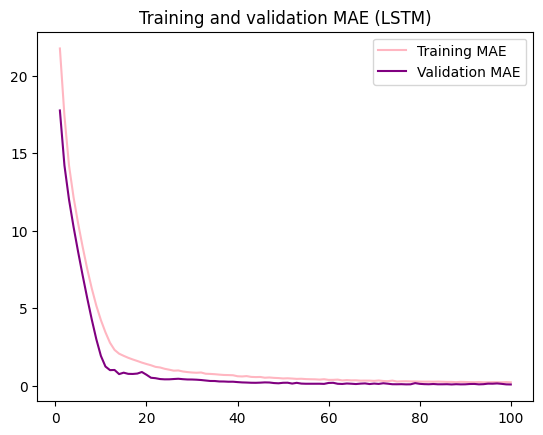

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MAE: 0.3853
MSE: 0.4587
RMSE: 0.6772


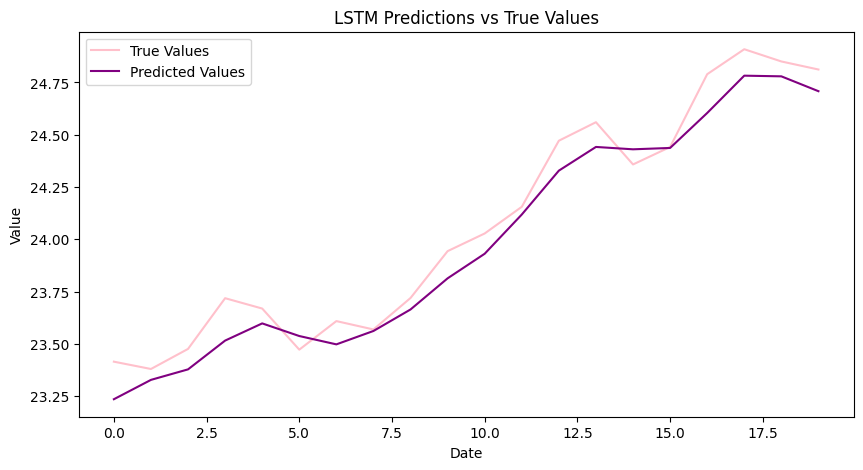

In [23]:
builder.graph_history(hist_lstm1_3)
y_true, predictions = builder.predict(model_lstm1_3)
builder.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder.graph_prediction(y_true, predictions)

In [73]:
model_lstm1_4, hist_lstm1_4 = builder.create_LSTM_model(num_neurons=32, epochs=100,
                                                  dropout_rate=0.2, use_recurrent_dropout=False,
                                                  name_model="LSTM1_4_32")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 453.2678 - mae: 20.9653 - val_loss: 275.3826 - val_mae: 16.5566
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 272.6586 - mae: 16.1170 - val_loss: 173.1862 - val_mae: 13.1060
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 184.8759 - mae: 13.0549 - val_loss: 121.2086 - val_mae: 10.9435
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 137.7362 - mae: 11.0817 - val_loss: 86.0203 - val_mae: 9.1957
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 103.5506 - mae: 9.4500 - val_loss: 59.3928 - val_mae: 7.6112
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 76.8119 - mae: 7.9783 - val_loss: 38.8819 - val_mae: 6.1170
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 55.8147 - mae: 6.6630 - val_loss: 23.5865 - val_mae: 4.7034
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 39.8860 - mae: 5.5003 - val_loss: 12.9699 - val_mae: 3.3919
Epoch 9/100
50/50 ━━━━━━━━━━━━━━

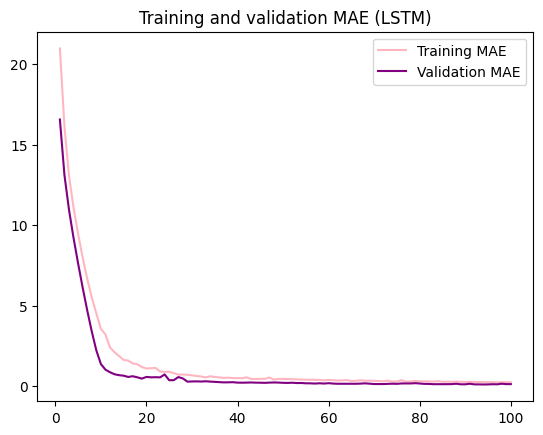

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 0.4595
MSE: 0.6342
RMSE: 0.7963


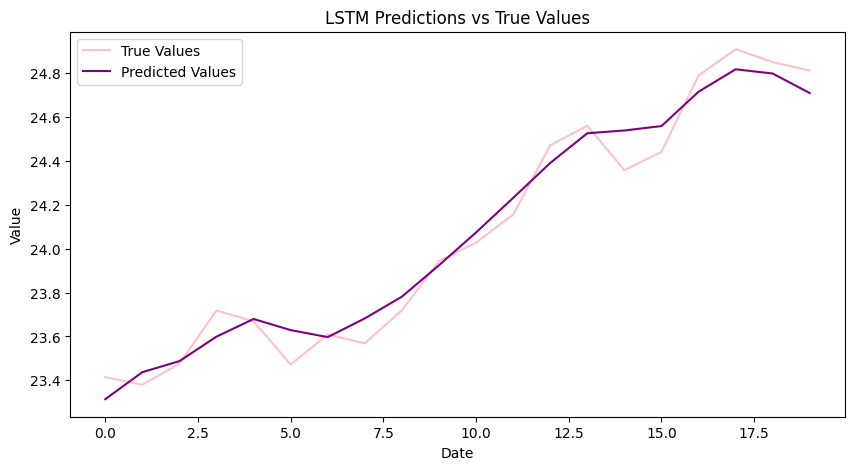

In [74]:
builder.graph_history(hist_lstm1_4)
y_true, predictions = builder.predict(model_lstm1_4)
builder.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder.graph_prediction(y_true, predictions)

In [24]:
model_lstm2_1, hist_lstm2_1 = builder2.create_LSTM_model(num_neurons=64, epochs=125,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM2_1_64")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 410.6568 - mae: 19.8739 - val_loss: 190.8818 - val_mae: 13.7631
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 214.1586 - mae: 14.0484 - val_loss: 115.4197 - val_mae: 10.6745
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 133.2971 - mae: 10.8165 - val_loss: 77.3327 - val_mae: 8.7094
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 96.2543 - mae: 9.0421 - val_loss: 52.2251 - val_mae: 7.1235
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 71.5416 - mae: 7.6142 - val_loss: 33.7123 - val_mae: 5.6772
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 51.2305 - mae: 6.3349 - val_loss: 20.0604 - val_mae: 4.3103
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 36.9423 - mae: 5.2426 - val_loss: 10.9133 - val_mae: 3.0710
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 27.0502 - mae: 4.3385 - val_loss: 5.4123 - val_mae: 2.0132
Epoch 9/125
25/25 ━━━━━━━━━━━━━

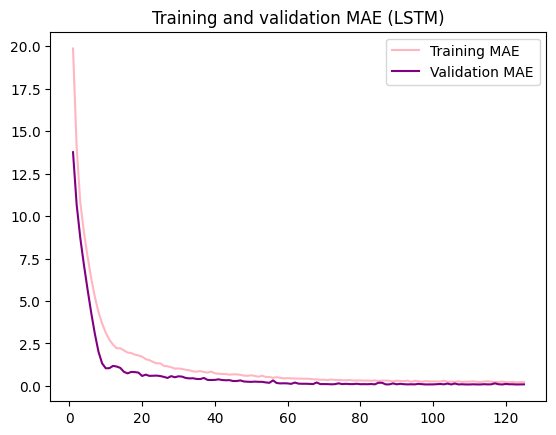

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE: 0.3112
MSE: 0.2875
RMSE: 0.5362


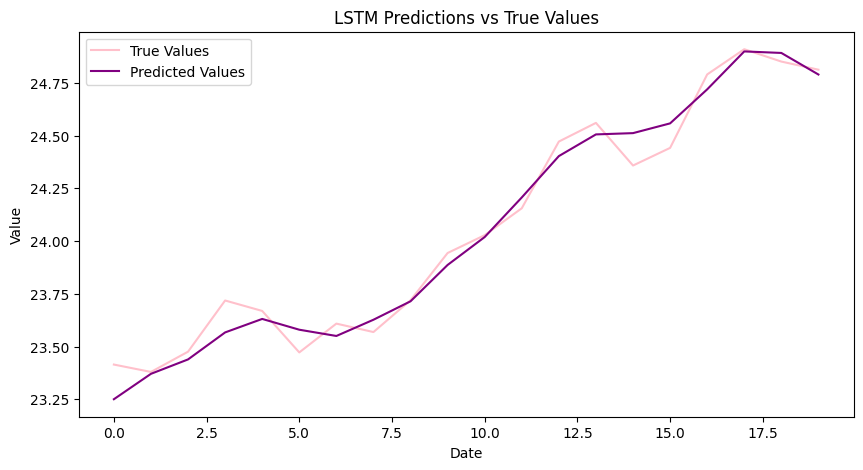

In [25]:
builder2.graph_history(hist_lstm2_1)
y_true, predictions = builder2.predict(model_lstm2_1)
builder2.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder2.graph_prediction(y_true, predictions)

In [26]:
model_lstm2_2, hist_lstm2_2 = builder2.create_LSTM_model(num_neurons=128, epochs=125,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM2_2_128")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 281.2860 - mae: 15.7124 - val_loss: 65.0265 - val_mae: 7.9718
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 73.9585 - mae: 7.5122 - val_loss: 21.1493 - val_mae: 4.4352
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 33.3743 - mae: 4.8940 - val_loss: 6.0080 - val_mae: 2.1439
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 19.6320 - mae: 3.5507 - val_loss: 1.7020 - val_mae: 1.0582
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 15.4334 - mae: 2.9171 - val_loss: 1.7492 - val_mae: 1.0776
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 8.8900 - mae: 2.1875 - val_loss: 2.2523 - val_mae: 1.2529
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 7.6174 - mae: 2.1709 - val_loss: 2.4107 - val_mae: 1.2923
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.4950 - mae: 1.9700 - val_loss: 1.3886 - val_mae: 0.9767
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/

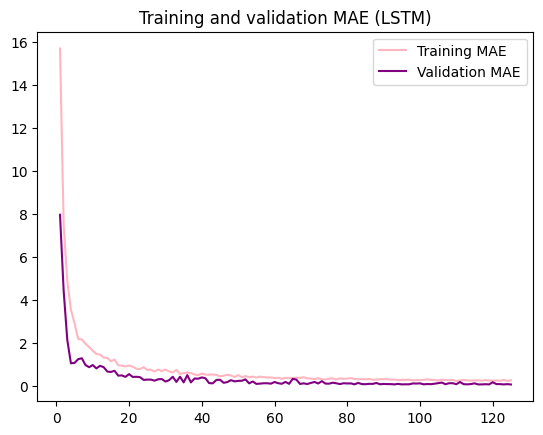

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE: 0.3486
MSE: 0.3830
RMSE: 0.6188


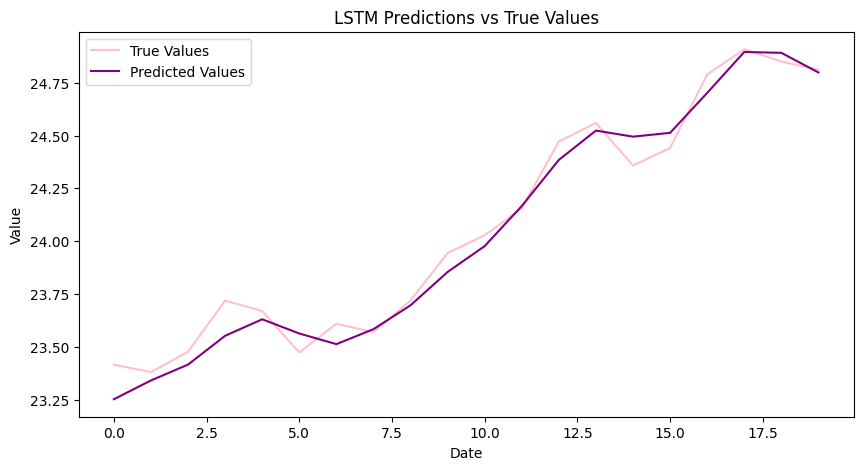

In [27]:
builder2.graph_history(hist_lstm2_2)
y_true, predictions = builder2.predict(model_lstm2_2)
builder2.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder2.graph_prediction(y_true, predictions)

In [28]:
model_lstm2_3, hist_lstm2_3 = builder2.create_LSTM_model(num_neurons=32, epochs=125,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM2_3_32")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 522.1522 - mae: 22.5477 - val_loss: 449.6606 - val_mae: 21.1697
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 456.6039 - mae: 21.0386 - val_loss: 334.3852 - val_mae: 18.2461
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 364.4467 - mae: 18.6925 - val_loss: 261.9231 - val_mae: 16.1385
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 290.0788 - mae: 16.5955 - val_loss: 211.5220 - val_mae: 14.4930
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 240.3796 - mae: 15.0326 - val_loss: 175.6763 - val_mae: 13.1985
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 204.8510 - mae: 13.7903 - val_loss: 148.7602 - val_mae: 12.1360
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 177.3627 - mae: 12.7553 - val_loss: 126.8959 - val_mae: 11.1989
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 154.7929 - mae: 11.8348 - val_loss: 108.2112 - val_mae: 10.3310
Epoch 9/

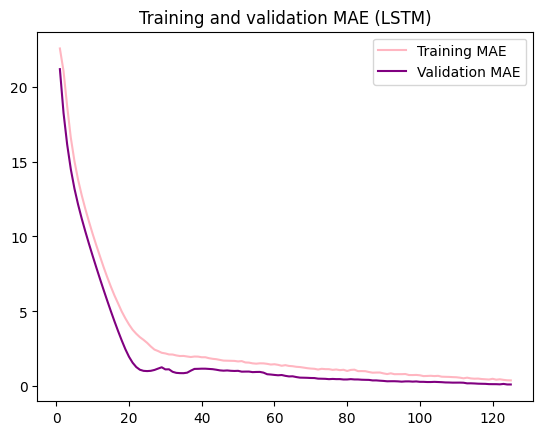

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 0.7809
MSE: 1.5409
RMSE: 1.2413


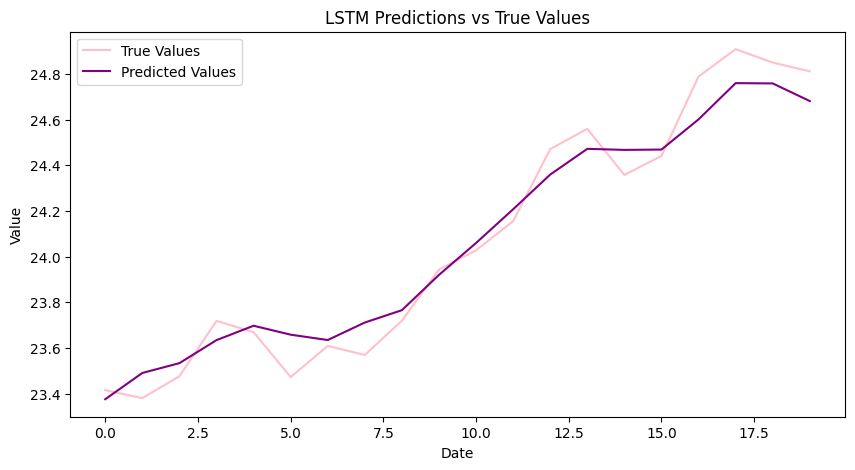

In [29]:
builder2.graph_history(hist_lstm2_3)
y_true, predictions = builder2.predict(model_lstm2_3)
builder2.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder2.graph_prediction(y_true, predictions)

In [75]:
model_lstm2_4, hist_lstm2_4 = builder2.create_LSTM_model(num_neurons=64, epochs=125,
                                                  dropout_rate=0.2, use_recurrent_dropout=False,
                                                  name_model="LSTM2_4_64")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 416.4587 - mae: 20.0159 - val_loss: 208.0368 - val_mae: 14.3727
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 216.0113 - mae: 14.0948 - val_loss: 120.1883 - val_mae: 10.8957
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 133.9523 - mae: 10.8733 - val_loss: 79.3785 - val_mae: 8.8261
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 96.7903 - mae: 9.0793 - val_loss: 52.9307 - val_mae: 7.1729
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 70.6269 - mae: 7.5832 - val_loss: 33.1424 - val_mae: 5.6268
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 50.3698 - mae: 6.2724 - val_loss: 19.4949 - val_mae: 4.2441
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 36.3174 - mae: 5.1911 - val_loss: 10.6243 - val_mae: 3.0235
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 26.7790 - mae: 4.3127 - val_loss: 5.3486 - val_mae: 1.9990
Epoch 9/125
25/25 ━━━━━━━━━━━━━

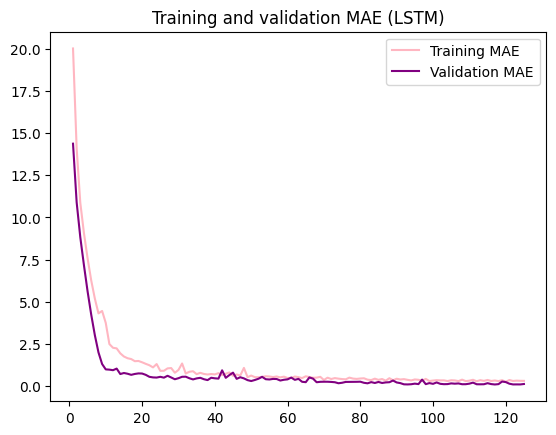

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MAE: 0.5235
MSE: 0.6749
RMSE: 0.8215


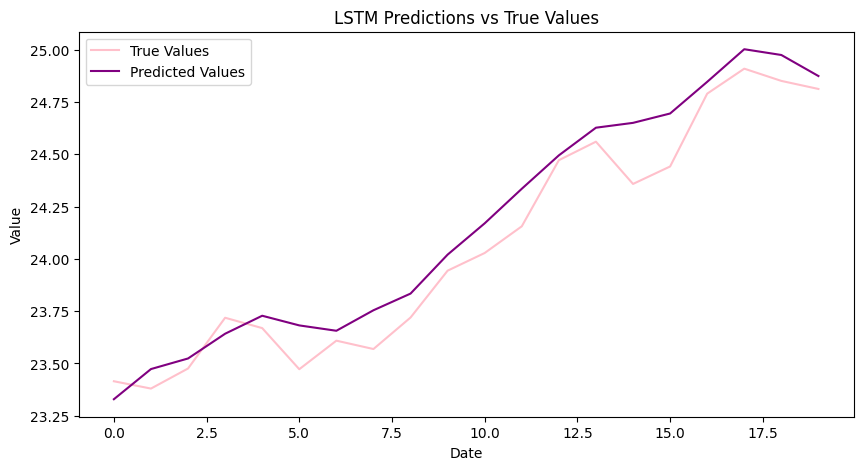

In [76]:
builder2.graph_history(hist_lstm2_4)
y_true, predictions = builder2.predict(model_lstm2_4)
builder2.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder2.graph_prediction(y_true, predictions)

In [30]:
model_lstm3_1, hist_lstm3_1 = builder3.create_LSTM_model(num_neurons=64, epochs=150,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM3_1_64")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 529.4277 - mae: 22.7052 - val_loss: 452.1153 - val_mae: 21.2246
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 406.2346 - mae: 19.7956 - val_loss: 245.3352 - val_mae: 15.6141
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 268.4488 - mae: 15.9099 - val_loss: 175.2436 - val_mae: 13.1796
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 198.2433 - mae: 13.5151 - val_loss: 134.4654 - val_mae: 11.5293
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 160.5414 - mae: 12.0524 - val_loss: 107.9203 - val_mae: 10.3142
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 134.0990 - mae: 10.9083 - val_loss: 87.6590 - val_mae: 9.2805
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 113.0901 - mae: 9.9188 - val_loss: 70.8249 - val_mae: 8.3244
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 95.8534 - mae: 9.0459 - val_loss: 57.6053 - val_mae: 7.4885
Epoch 9/150
12/12

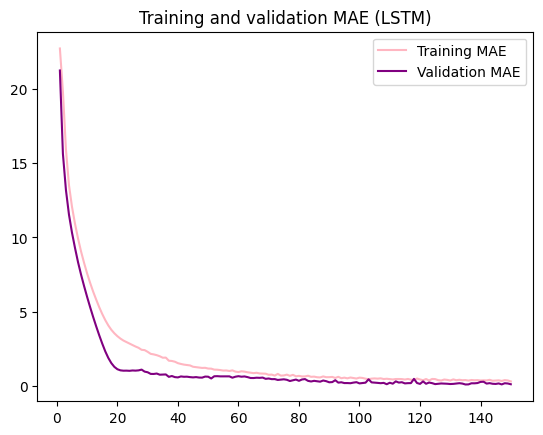

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
MAE: 0.4559
MSE: 0.4427
RMSE: 0.6653


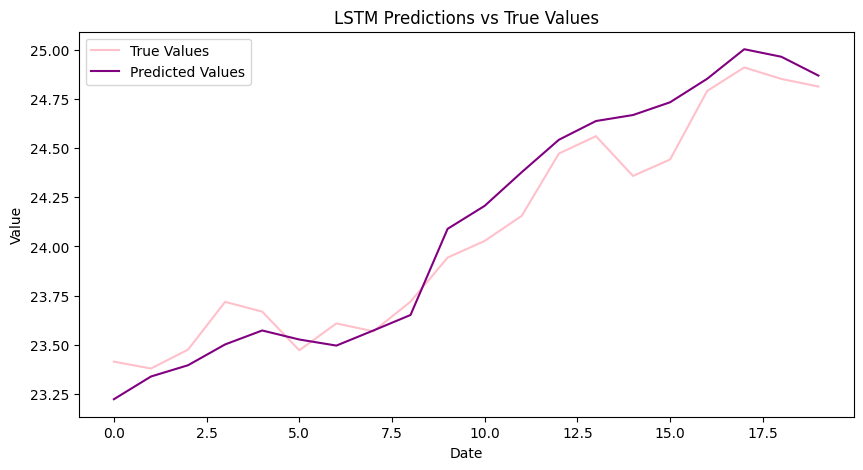

In [31]:
builder3.graph_history(hist_lstm3_1)
y_true, predictions = builder3.predict(model_lstm3_1)
builder3.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder3.graph_prediction(y_true, predictions)

In [32]:
model_lstm3_2, hist_lstm3_2 = builder3.create_LSTM_model(num_neurons=128, epochs=150,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM3_2_128")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 421.1020 - mae: 20.0405 - val_loss: 160.4910 - val_mae: 12.6082
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 179.5513 - mae: 12.6405 - val_loss: 81.5351 - val_mae: 8.9445
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 98.2685 - mae: 9.0762 - val_loss: 49.3274 - val_mae: 6.9136
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 67.4152 - mae: 7.3641 - val_loss: 29.5399 - val_mae: 5.2925
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 47.8025 - mae: 6.0752 - val_loss: 17.4950 - val_mae: 3.9958
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 35.3615 - mae: 5.0986 - val_loss: 9.9587 - val_mae: 2.9035
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 26.9530 - mae: 4.3210 - val_loss: 5.3034 - val_mae: 1.9798
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 21.5021 - mae: 3.7590 - val_loss: 2.8528 - val_mae: 1.3753
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━

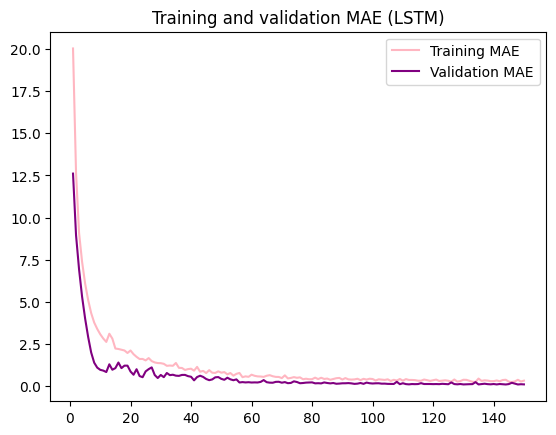

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
MAE: 0.3387
MSE: 0.2875
RMSE: 0.5362


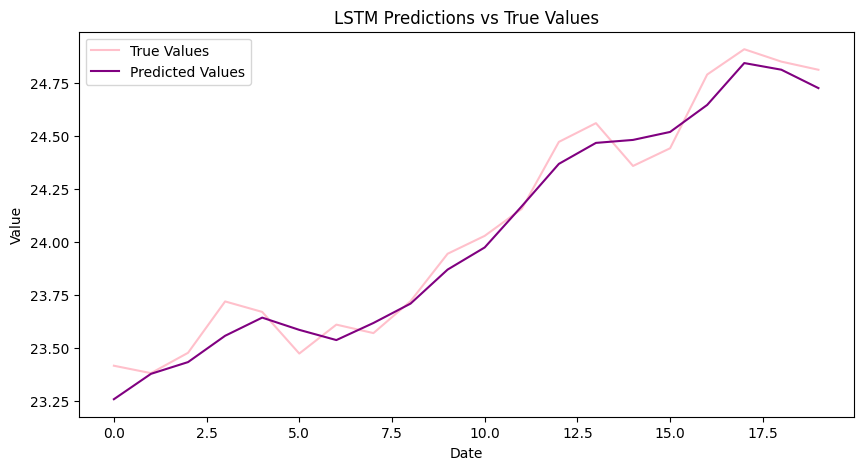

In [33]:
builder3.graph_history(hist_lstm3_2)
y_true, predictions = builder3.predict(model_lstm3_2)
builder3.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder3.graph_prediction(y_true, predictions)

In [34]:
model_lstm3_3, hist_lstm3_3 = builder3.create_LSTM_model(num_neurons=32, epochs=150,
                                                  dropout_rate=0.2, use_recurrent_dropout=True,
                                                  name_model="LSTM3_3_32")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 530.3448 - mae: 22.6911 - val_loss: 456.9680 - val_mae: 21.3403
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 505.7646 - mae: 22.1571 - val_loss: 421.3172 - val_mae: 20.4871
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 459.5955 - mae: 21.0886 - val_loss: 364.5182 - val_mae: 19.0513
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 406.9881 - mae: 19.8085 - val_loss: 316.4336 - val_mae: 17.7450
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 360.5248 - mae: 18.6032 - val_loss: 279.9700 - val_mae: 16.6860
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 322.1314 - mae: 17.5425 - val_loss: 250.0052 - val_mae: 15.7626
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 290.5363 - mae: 16.6161 - val_loss: 225.3599 - val_mae: 14.9606
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 264.8454 - mae: 15.8194 - val_loss: 204.7949 - val_mae: 14.2569
Epoch 9/

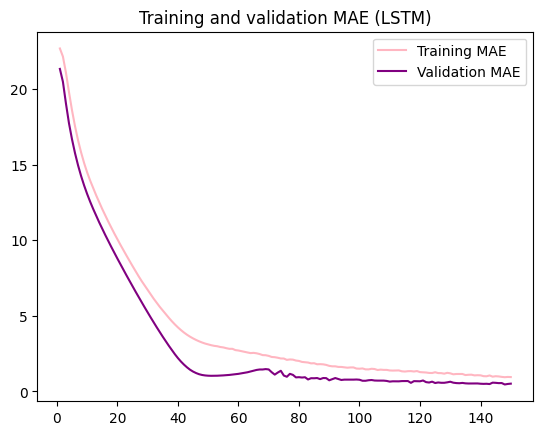

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
MAE: 1.4356
MSE: 4.0065
RMSE: 2.0016


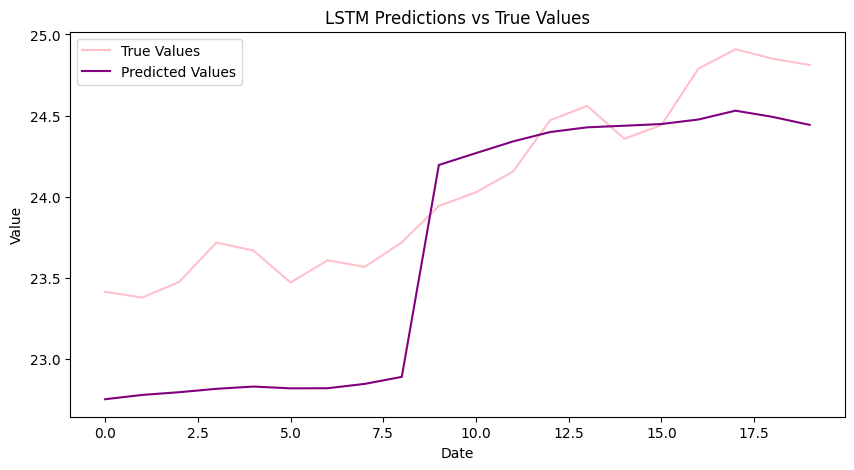

In [35]:
builder3.graph_history(hist_lstm3_3)
y_true, predictions = builder3.predict(model_lstm3_3)
builder3.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder3.graph_prediction(y_true, predictions)

In [77]:
model_lstm3_4, hist_lstm3_4 = builder3.create_LSTM_model(num_neurons=128, epochs=150,
                                                  dropout_rate=0.2, use_recurrent_dropout=False,
                                                  name_model="LSTM3_4_128")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 419.7458 - mae: 20.0601 - val_loss: 200.1127 - val_mae: 13.8158
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 215.0454 - mae: 14.1938 - val_loss: 88.9386 - val_mae: 9.3489
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 127.6368 - mae: 10.3853 - val_loss: 55.2766 - val_mae: 7.3310
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 73.1213 - mae: 7.7193 - val_loss: 34.6750 - val_mae: 5.7571
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 52.9017 - mae: 6.4365 - val_loss: 21.0479 - val_mae: 4.4180
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 38.8512 - mae: 5.3889 - val_loss: 12.0551 - val_mae: 3.2445
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 29.1780 - mae: 4.5369 - val_loss: 6.4768 - val_mae: 2.2343
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 22.8326 - mae: 3.9008 - val_loss: 3.3958 - val_mae: 1.5197
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━

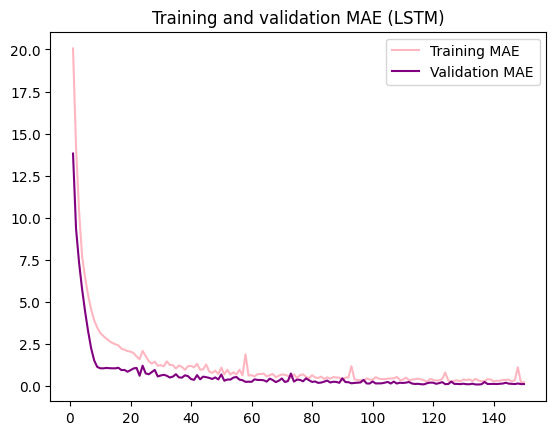

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
MAE: 0.3620
MSE: 0.2688
RMSE: 0.5185


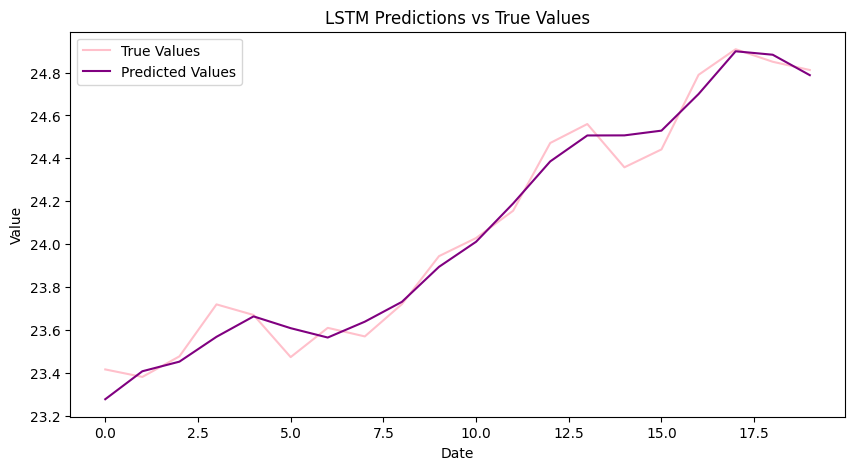

In [78]:
builder3.graph_history(hist_lstm3_4)
y_true, predictions = builder3.predict(model_lstm3_4)
builder3.calculate_metrics(y_true, predictions)

# Ahora puedes graficar con confianza
builder3.graph_prediction(y_true, predictions)

# Punto 3

In [36]:
model_gru1_1, hist_gru1_1 = builder.create_GRU_model(num_neurons=32, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU1_1_32")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 481.4857 - mae: 21.6896 - val_loss: 266.4758 - val_mae: 16.2834
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 272.9370 - mae: 16.1509 - val_loss: 164.8888 - val_mae: 12.7860
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 185.2090 - mae: 13.0758 - val_loss: 121.2393 - val_mae: 10.9446
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 140.9948 - mae: 11.2348 - val_loss: 88.6820 - val_mae: 9.3391
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 107.1453 - mae: 9.6310 - val_loss: 62.2991 - val_mae: 7.7997
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 80.0540 - mae: 8.1684 - val_loss: 41.3319 - val_mae: 6.3140
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 58.6224 - mae: 6.8446 - val_loss: 25.4297 - val_mae: 4.8953
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 42.0837 - mae: 5.6674 - val_loss: 14.2120 - val_mae: 3.5703
Epoch 9/100
50/50 ━━━━━━━━━━━

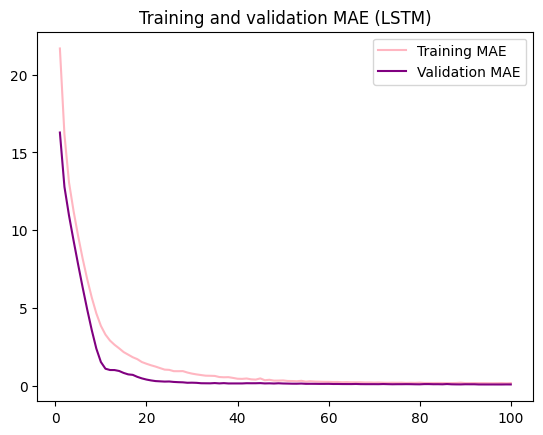

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 0.2624
MSE: 0.2120
RMSE: 0.4605


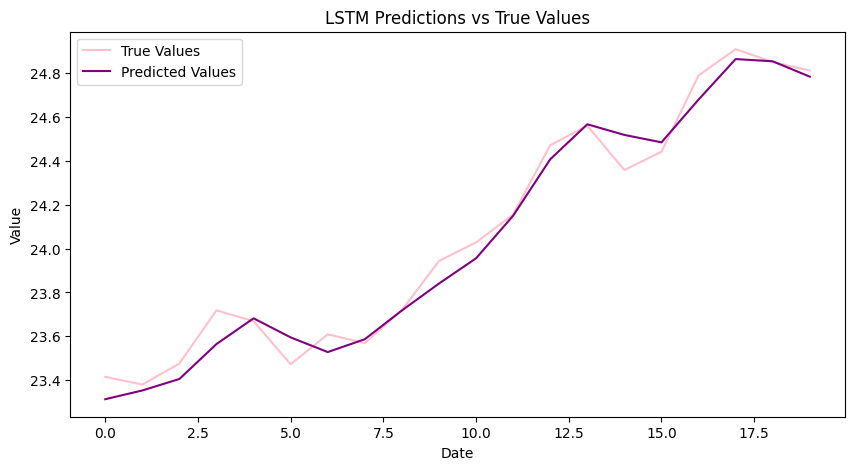

In [79]:
builder.graph_history(hist_gru1_1)
y_trueG,predictionsG = builder.predict(model_gru1_1)
builder.calculate_metrics(y_trueG, predictionsG)
builder.graph_prediction(y_trueG,predictionsG)

In [38]:
model_gru1_2, hist_gru1_2 = builder.create_GRU_model(num_neurons=64, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU1_2_64")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 354.6303 - mae: 18.1843 - val_loss: 118.4644 - val_mae: 10.8160
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 146.7872 - mae: 11.2583 - val_loss: 57.9520 - val_mae: 7.5148
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 69.3905 - mae: 7.3432 - val_loss: 22.7747 - val_mae: 4.6160
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 35.7426 - mae: 5.0466 - val_loss: 6.7483 - val_mae: 2.3061
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 20.1979 - mae: 3.5992 - val_loss: 1.8995 - val_mae: 1.1205
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 15.9080 - mae: 2.9354 - val_loss: 1.5185 - val_mae: 1.0192
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 14.4934 - mae: 2.7039 - val_loss: 1.7918 - val_mae: 1.0717
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 11.6828 - mae: 2.4566 - val_loss: 1.5241 - val_mae: 0.9886
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 

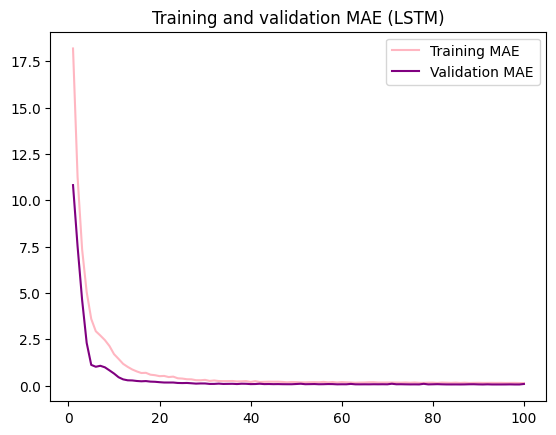

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE: 0.2596
MSE: 0.1704
RMSE: 0.4128


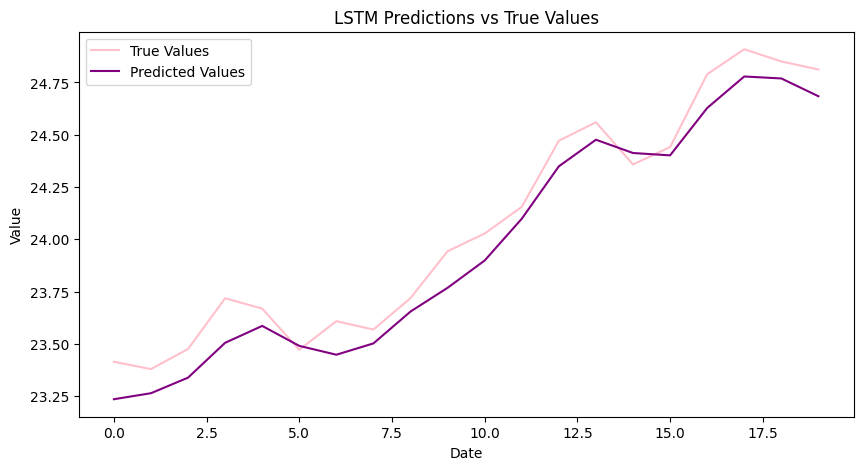

In [80]:
builder.graph_history(hist_gru1_2)
y_trueG,predictionsG = builder.predict(model_gru1_2)
builder.calculate_metrics(y_trueG, predictionsG)
builder.graph_prediction(y_trueG,predictionsG)

In [40]:
model_gru1_3, hist_gru1_3 = builder.create_GRU_model(num_neurons=128, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU1_3_128")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 196.5910 - mae: 12.3659 - val_loss: 18.5228 - val_mae: 4.1320
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 29.5544 - mae: 4.2606 - val_loss: 1.7688 - val_mae: 1.0863
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 13.0769 - mae: 2.5706 - val_loss: 1.7306 - val_mae: 1.0534
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 15.7059 - mae: 2.3703 - val_loss: 1.8309 - val_mae: 1.0891
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.8776 - mae: 1.6520 - val_loss: 1.8264 - val_mae: 1.1414
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.3160 - mae: 1.3642 - val_loss: 0.4220 - val_mae: 0.5477
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8474 - mae: 0.9713 - val_loss: 0.1790 - val_mae: 0.3322
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3711 - mae: 0.8818 - val_loss: 0.1813 - val_mae: 0.3062
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/st

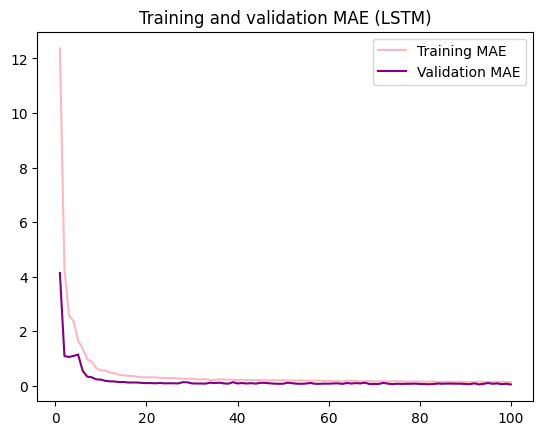

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 0.2252
MSE: 0.1358
RMSE: 0.3685


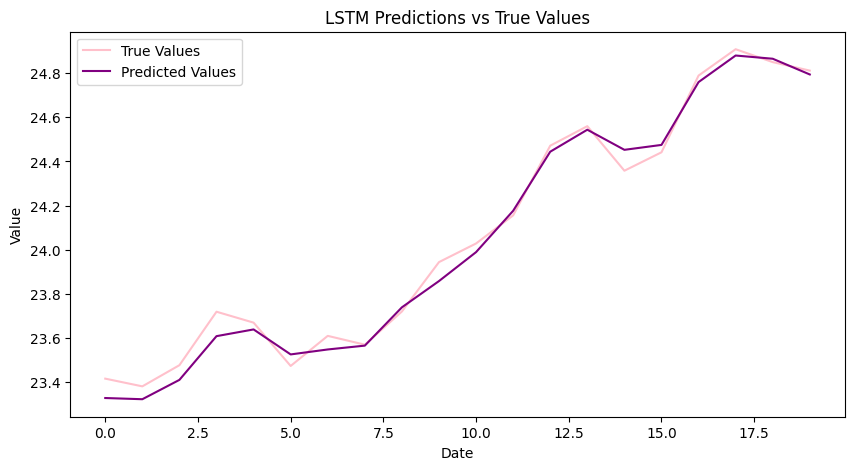

In [81]:
builder.graph_history(hist_gru1_3)
y_trueG,predictionsG = builder.predict(model_gru1_3)
builder.calculate_metrics(y_trueG, predictionsG)
builder.graph_prediction(y_trueG,predictionsG)

In [97]:
model_gru1_4, hist_gru1_4 = builder.create_GRU_model(num_neurons=128, epochs=100,
                                               dropout_rate=0.2, use_recurrent_dropout=False,
                                               name_model="GRU1_4_128")

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 212.3750 - mae: 13.0787 - val_loss: 32.6673 - val_mae: 5.5848
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 50.8106 - mae: 5.4727 - val_loss: 3.3726 - val_mae: 1.5287
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 20.6973 - mae: 3.1623 - val_loss: 1.5510 - val_mae: 1.0275
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 12.2494 - mae: 2.5315 - val_loss: 1.5587 - val_mae: 1.0109
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 18.8524 - mae: 2.6169 - val_loss: 1.3977 - val_mae: 0.9492
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.3599 - mae: 1.8411 - val_loss: 1.4072 - val_mae: 0.9613
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.6872 - mae: 1.4255 - val_loss: 0.8327 - val_mae: 0.7704
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0304 - mae: 1.0127 - val_loss: 0.2782 - val_mae: 0.3780
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/s

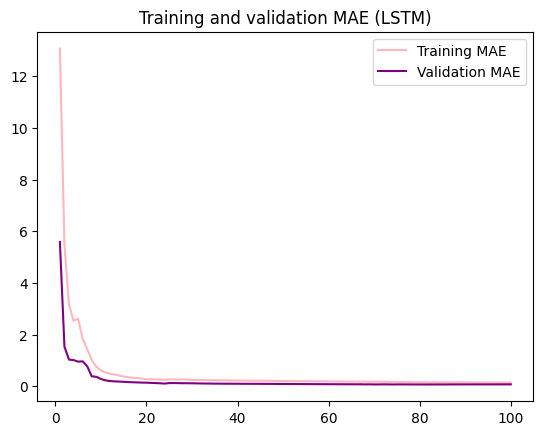

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MAE: 0.2846
MSE: 0.2052
RMSE: 0.4529


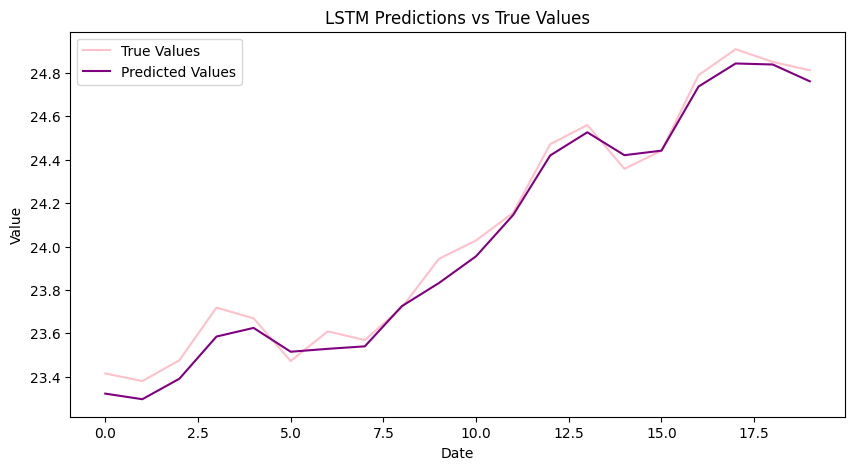

In [98]:
builder.graph_history(hist_gru1_4)
y_trueG,predictionsG = builder.predict(model_gru1_4)
builder.calculate_metrics(y_trueG, predictionsG)
builder.graph_prediction(y_trueG,predictionsG)

In [42]:
model_gru2_1, hist_gru2_1 = builder2.create_GRU_model(num_neurons=32, epochs=125,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU2_1_32")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 525.1973 - mae: 22.6475 - val_loss: 453.4705 - val_mae: 21.2600
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 492.8806 - mae: 21.9461 - val_loss: 403.6016 - val_mae: 20.0524
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 359.5118 - mae: 18.5334 - val_loss: 201.6463 - val_mae: 14.1480
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 231.8462 - mae: 14.7212 - val_loss: 155.5975 - val_mae: 12.4143
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 187.2212 - mae: 13.1338 - val_loss: 131.1415 - val_mae: 11.3868
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 160.5704 - mae: 12.0755 - val_loss: 111.3213 - val_mae: 10.4804
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 138.9839 - mae: 11.1451 - val_loss: 94.2493 - val_mae: 9.6315
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 120.8389 - mae: 10.3090 - val_loss: 79.4045 - val_mae: 8.8273
Epoch 9/125


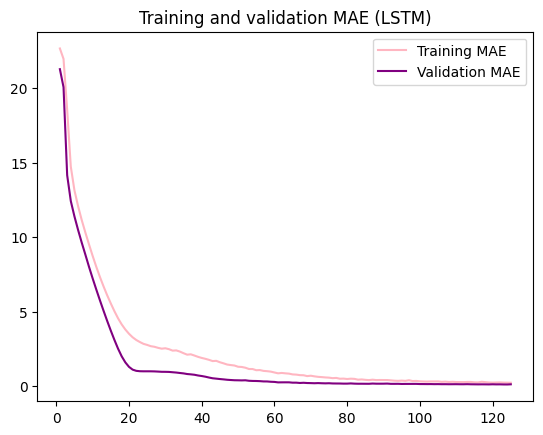

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 0.3636
MSE: 0.3941
RMSE: 0.6278


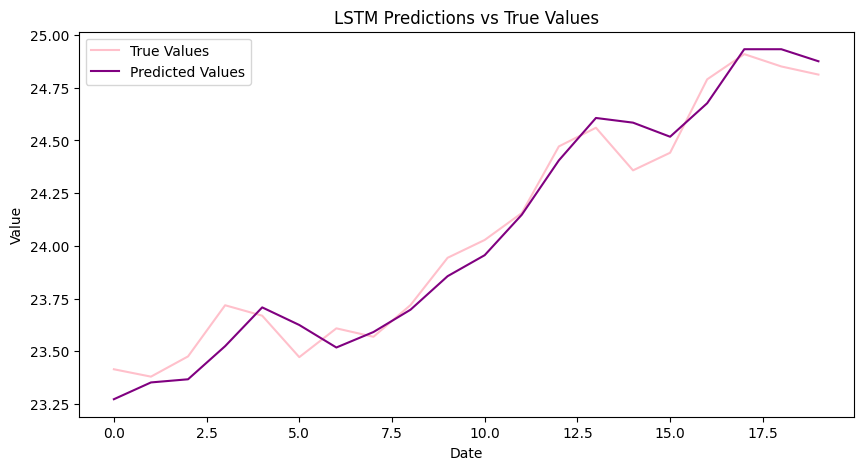

In [82]:
builder2.graph_history(hist_gru2_1)
y_trueG,predictionsG = builder2.predict(model_gru2_1)
builder2.calculate_metrics(y_trueG, predictionsG)
builder2.graph_prediction(y_trueG,predictionsG)

In [44]:
model_gru2_2, hist_gru2_2 = builder2.create_GRU_model(num_neurons=64, epochs=125,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU2_2_64")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 520.4364 - mae: 22.5400 - val_loss: 433.7880 - val_mae: 20.7917
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 309.3166 - mae: 17.1033 - val_loss: 161.5026 - val_mae: 12.6500
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 180.1265 - mae: 12.7899 - val_loss: 109.0898 - val_mae: 10.3732
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 128.8583 - mae: 10.6461 - val_loss: 76.6314 - val_mae: 8.6688
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 96.2656 - mae: 9.0531 - val_loss: 53.0005 - val_mae: 7.1775
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 71.8504 - mae: 7.6620 - val_loss: 34.9300 - val_mae: 5.7833
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 53.1857 - mae: 6.4653 - val_loss: 21.4921 - val_mae: 4.4731
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 38.6118 - mae: 5.3796 - val_loss: 11.9448 - val_mae: 3.2344
Epoch 9/125
25/25 ━━━━━━━━

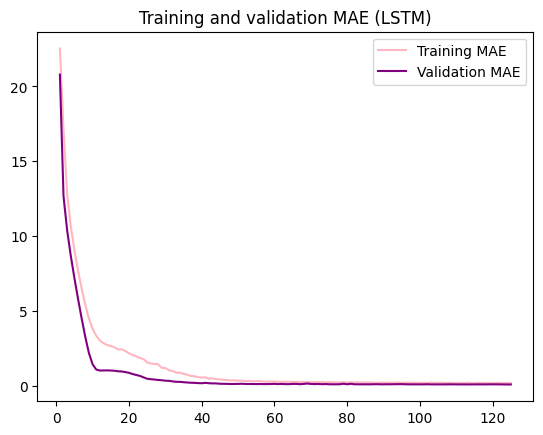

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 0.2454
MSE: 0.1546
RMSE: 0.3932


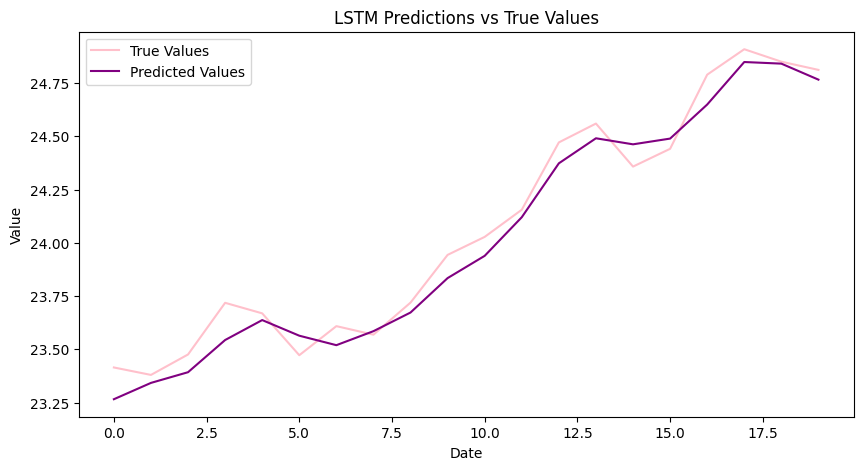

In [83]:
builder2.graph_history(hist_gru2_2)
y_trueG,predictionsG = builder2.predict(model_gru2_2)
builder2.calculate_metrics(y_trueG, predictionsG)
builder2.graph_prediction(y_trueG,predictionsG)

In [46]:
model_gru2_3, hist_gru2_3 = builder2.create_GRU_model(num_neurons=128, epochs=125,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU2_3_128")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 350.1926 - mae: 17.7514 - val_loss: 72.1392 - val_mae: 8.4051
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 106.1112 - mae: 9.1394 - val_loss: 27.2550 - val_mae: 5.0758
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 39.7464 - mae: 5.3945 - val_loss: 8.1078 - val_mae: 2.5734
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 22.0491 - mae: 3.8008 - val_loss: 2.1654 - val_mae: 1.1883
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 17.7599 - mae: 3.0833 - val_loss: 1.4373 - val_mae: 1.0011
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 15.3027 - mae: 2.7718 - val_loss: 1.4674 - val_mae: 0.9982
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 11.7951 - mae: 2.5088 - val_loss: 1.2827 - val_mae: 0.9363
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 10.0108 - mae: 2.3031 - val_loss: 1.0663 - val_mae: 0.8556
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3

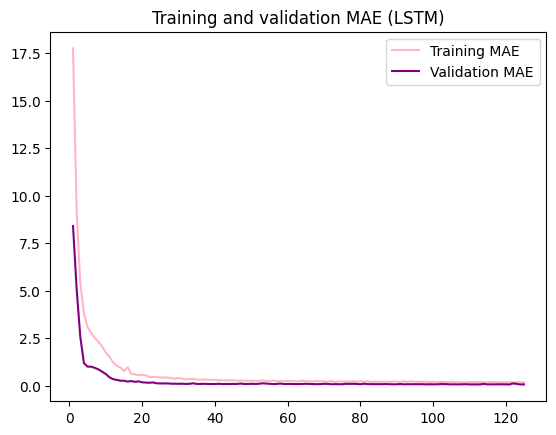

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MAE: 0.2372
MSE: 0.1484
RMSE: 0.3852


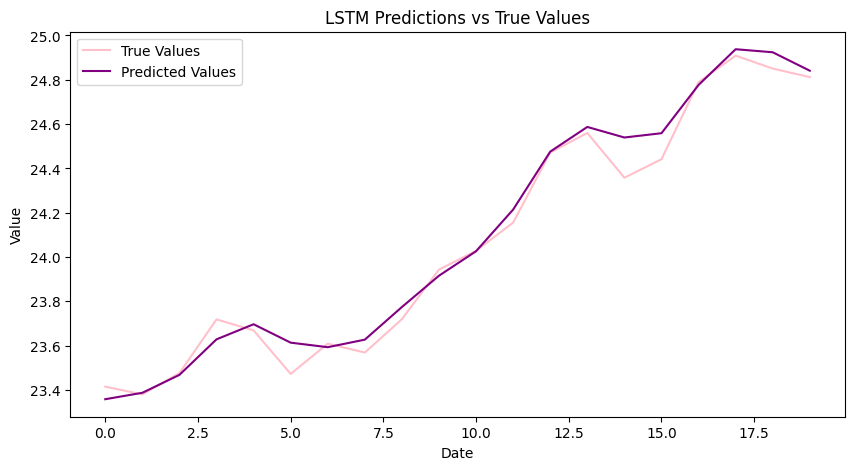

In [84]:
builder2.graph_history(hist_gru2_3)
y_trueG,predictionsG = builder2.predict(model_gru2_3)
builder2.calculate_metrics(y_trueG, predictionsG)
builder2.graph_prediction(y_trueG,predictionsG)

In [99]:
model_gru2_4, hist_gru2_4 = builder2.create_GRU_model(num_neurons=128, epochs=125,
                                               dropout_rate=0.2, use_recurrent_dropout=False,
                                               name_model="GRU2_4_128")

Epoch 1/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 360.6351 - mae: 18.1926 - val_loss: 98.7202 - val_mae: 9.8589
Epoch 2/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 141.5167 - mae: 11.0138 - val_loss: 43.4165 - val_mae: 6.4737
Epoch 3/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 57.7557 - mae: 6.5427 - val_loss: 15.7325 - val_mae: 3.7728
Epoch 4/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 29.4019 - mae: 4.5189 - val_loss: 4.4271 - val_mae: 1.7861
Epoch 5/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 24.9209 - mae: 3.5578 - val_loss: 1.6730 - val_mae: 1.0528
Epoch 6/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 15.3539 - mae: 2.9204 - val_loss: 1.5437 - val_mae: 1.0313
Epoch 7/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 14.3507 - mae: 2.7688 - val_loss: 1.7106 - val_mae: 1.0690
Epoch 8/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 15.4026 - mae: 2.7208 - val_loss: 1.5761 - val_mae: 1.0316
Epoch 9/125
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s

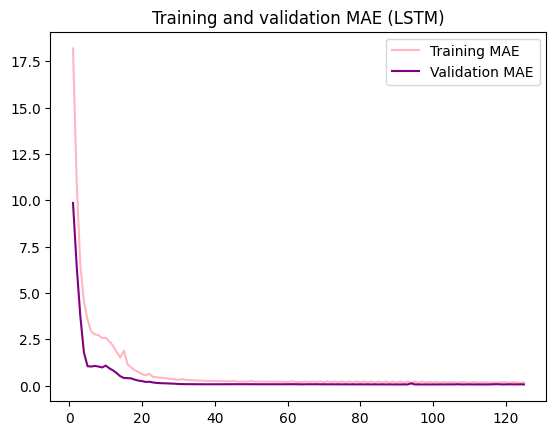

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE: 0.2116
MSE: 0.1330
RMSE: 0.3647


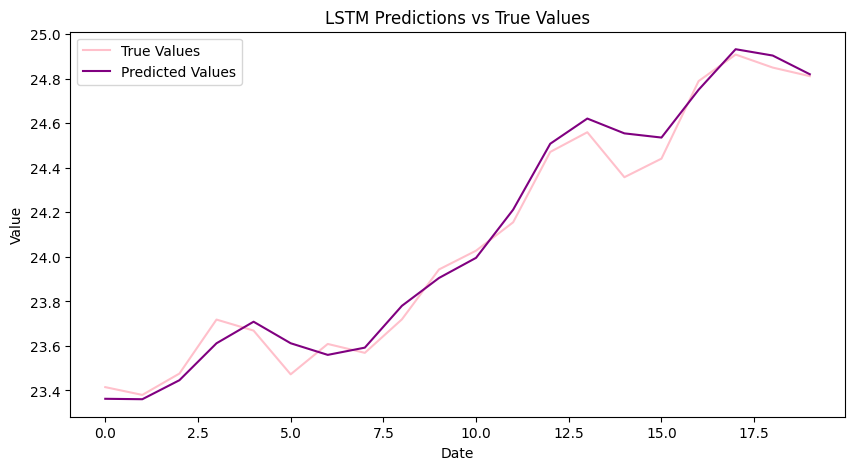

In [100]:
builder2.graph_history(hist_gru2_4)
y_trueG,predictionsG = builder2.predict(model_gru2_4)
builder2.calculate_metrics(y_trueG, predictionsG)
builder2.graph_prediction(y_trueG,predictionsG)

In [48]:
model_gru3_1, hist_gru3_1 = builder3.create_GRU_model(num_neurons=32, epochs=150,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU3_1_32")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 529.6469 - mae: 22.7636 - val_loss: 478.8199 - val_mae: 21.8444
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 517.2836 - mae: 22.5024 - val_loss: 470.9833 - val_mae: 21.6632
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 503.9178 - mae: 22.2169 - val_loss: 460.2208 - val_mae: 21.4116
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 483.8513 - mae: 21.7755 - val_loss: 440.0890 - val_mae: 20.9313
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 436.3463 - mae: 20.6630 - val_loss: 354.9243 - val_mae: 18.7595
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 340.8225 - mae: 18.1247 - val_loss: 228.1937 - val_mae: 15.0548
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 273.0613 - mae: 16.1396 - val_loss: 195.0505 - val_mae: 13.9115
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 236.6361 - mae: 14.9228 - val_loss: 175.6033 - val_mae: 13.1941
Epoch 9/

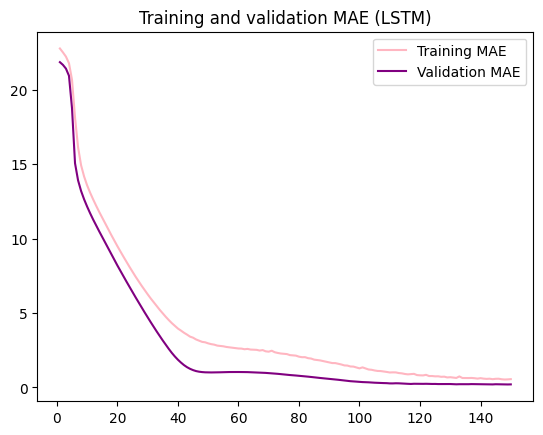

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MAE: 1.0217
MSE: 2.6958
RMSE: 1.6419


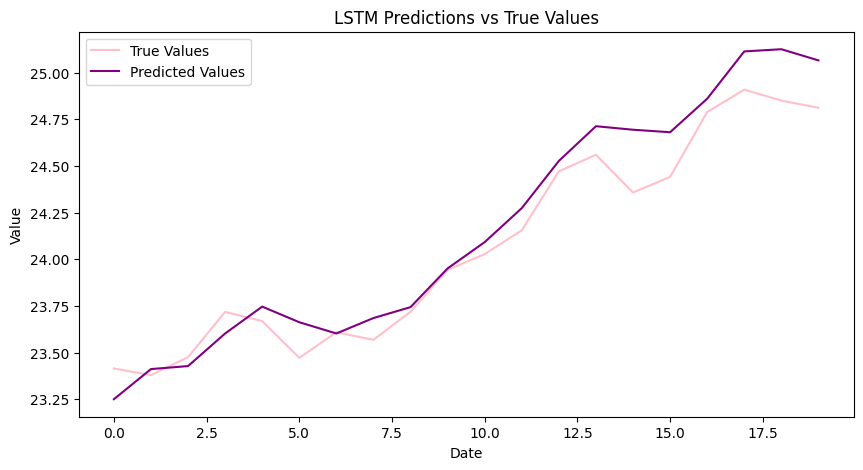

In [85]:
builder3.graph_history(hist_gru3_1)
y_trueG,predictionsG = builder3.predict(model_gru3_1)
builder3.calculate_metrics(y_trueG, predictionsG)
builder3.graph_prediction(y_trueG,predictionsG)

In [50]:
model_gru3_2, hist_gru3_2 = builder3.create_GRU_model(num_neurons=64, epochs=150,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU3_2_64")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 528.6763 - mae: 22.7363 - val_loss: 462.8175 - val_mae: 21.4743
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 503.0325 - mae: 22.1964 - val_loss: 441.6997 - val_mae: 20.9710
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 398.8345 - mae: 19.6229 - val_loss: 185.8462 - val_mae: 13.5726
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 230.2623 - mae: 14.6873 - val_loss: 125.1119 - val_mae: 11.1170
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 166.7334 - mae: 12.3192 - val_loss: 95.8677 - val_mae: 9.7132
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 125.0390 - mae: 10.5037 - val_loss: 76.1600 - val_mae: 8.6392
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 102.9294 - mae: 9.4128 - val_loss: 61.9487 - val_mae: 7.7732
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 87.5727 - mae: 8.5963 - val_loss: 50.0952 - val_mae: 6.9691
Epoch 9/150
12/12 ━

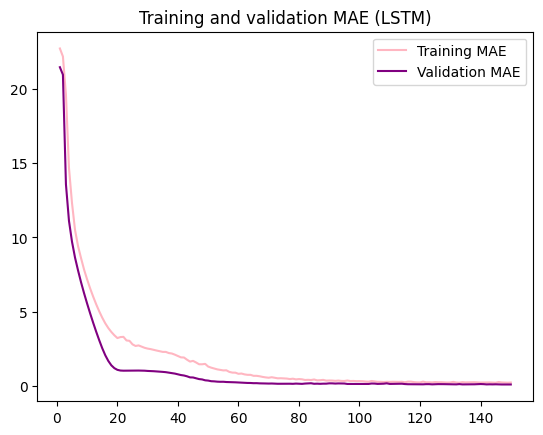

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.2643
MSE: 0.1790
RMSE: 0.4231


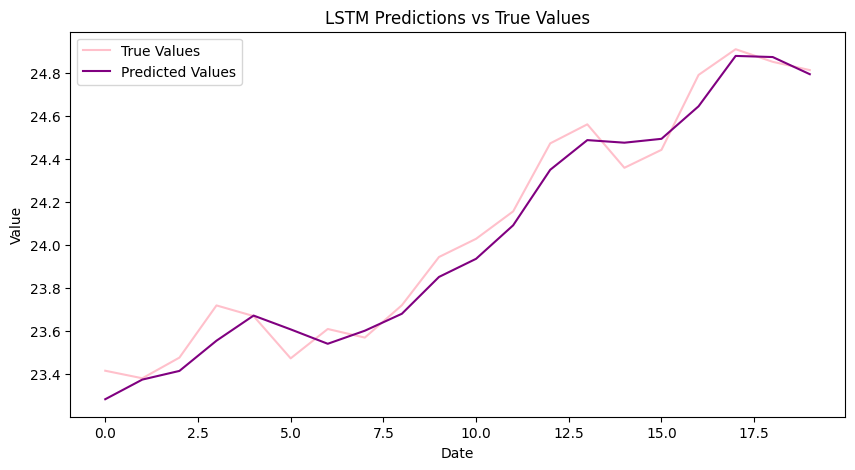

In [86]:
builder3.graph_history(hist_gru3_2)
y_trueG,predictionsG = builder3.predict(model_gru3_2)
builder3.calculate_metrics(y_trueG, predictionsG)
builder3.graph_prediction(y_trueG,predictionsG)

In [52]:
model_gru3_3, hist_gru3_3 = builder3.create_GRU_model(num_neurons=128, epochs=150,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU3_3_128")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 526.2738 - mae: 22.6926 - val_loss: 445.8744 - val_mae: 21.0702
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 270.5631 - mae: 15.7460 - val_loss: 77.5322 - val_mae: 8.7185
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 115.5543 - mae: 9.8138 - val_loss: 45.6790 - val_mae: 6.6450
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 65.5017 - mae: 7.2410 - val_loss: 27.7550 - val_mae: 5.1219
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 46.4441 - mae: 5.9636 - val_loss: 15.8807 - val_mae: 3.7890
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 33.7937 - mae: 4.9561 - val_loss: 8.7294 - val_mae: 2.6839
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 25.7670 - mae: 4.1983 - val_loss: 4.5775 - val_mae: 1.8142
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 21.5305 - mae: 3.6839 - val_loss: 2.5015 - val_mae: 1.2816
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━

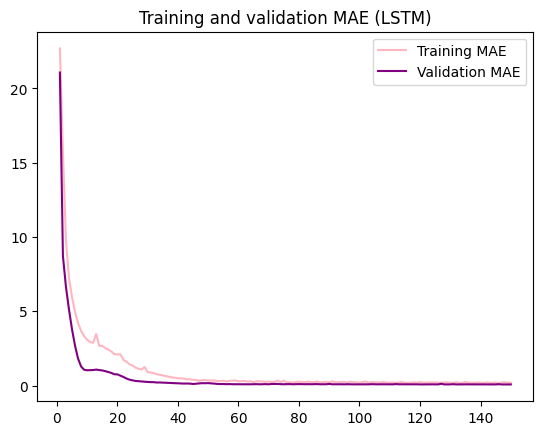

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE: 0.1958
MSE: 0.0907
RMSE: 0.3012


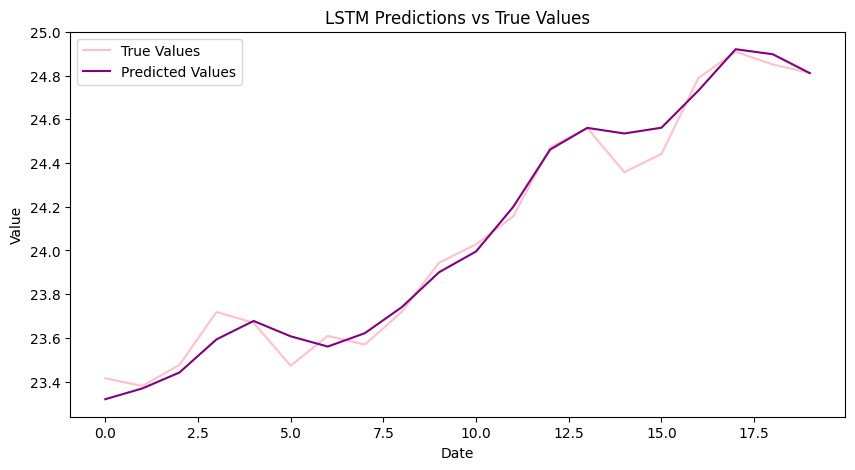

In [87]:
builder3.graph_history(hist_gru3_3)
y_trueG,predictionsG = builder3.predict(model_gru3_3)
builder3.calculate_metrics(y_trueG, predictionsG)
builder3.graph_prediction(y_trueG,predictionsG)

In [101]:
model_gru3_4, hist_gru3_4 = builder3.create_GRU_model(num_neurons=128, epochs=150,
                                               dropout_rate=0.2, use_recurrent_dropout=True,
                                               name_model="GRU3_4_128")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 525.0290 - mae: 22.6917 - val_loss: 454.8868 - val_mae: 21.2797
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 275.4040 - mae: 15.8488 - val_loss: 68.3306 - val_mae: 8.1741
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 115.9037 - mae: 9.7591 - val_loss: 35.2922 - val_mae: 5.8115
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 54.7062 - mae: 6.5346 - val_loss: 20.0711 - val_mae: 4.3070
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 38.0410 - mae: 5.3018 - val_loss: 10.1495 - val_mae: 2.9369
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 27.2663 - mae: 4.3327 - val_loss: 4.8825 - val_mae: 1.8840
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 20.8477 - mae: 3.6841 - val_loss: 2.4193 - val_mae: 1.2592
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 17.3863 - mae: 3.2627 - val_loss: 1.6160 - val_mae: 1.0464
Epoch 9/150
12/12 ━━━━━━━━━━━━━━━━━━

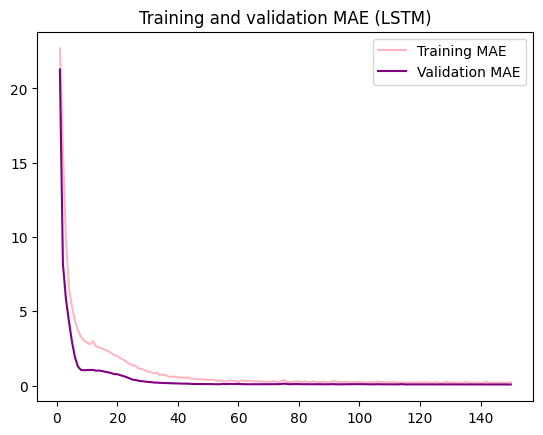

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
MAE: 0.3171
MSE: 0.2137
RMSE: 0.4623


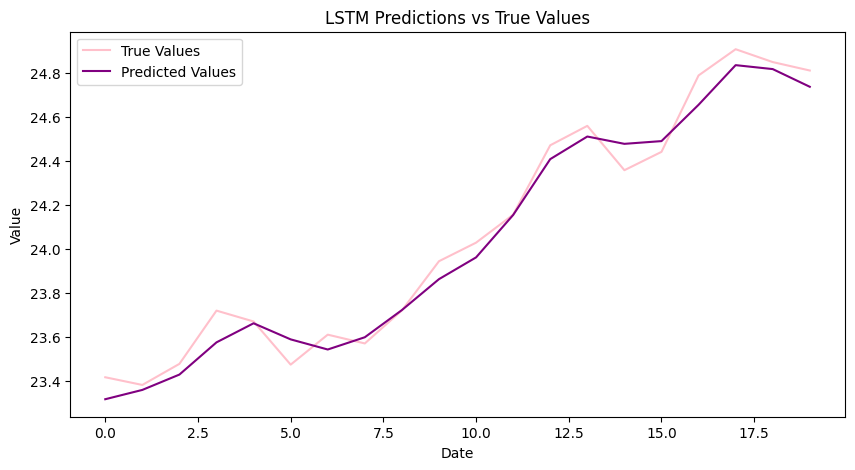

In [102]:
builder3.graph_history(hist_gru3_4)
y_trueG,predictionsG = builder3.predict(model_gru3_4)
builder3.calculate_metrics(y_trueG, predictionsG)
builder3.graph_prediction(y_trueG,predictionsG)

# Punto 4

In [54]:
model_stack1_1, hist_stack1_1 = builder.create_stacked_GRU(num_l1=64, num_l2=32, epochs=50,
                                                     name_model="Stacked_GRU1_1_64_32")

Epoch 1/50


C:\Users\lenovo\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 372.7243 - mae: 18.9276 - val_loss: 195.9912 - val_mae: 13.9473
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 221.0494 - mae: 14.3872 - val_loss: 147.8840 - val_mae: 12.1004
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 167.1344 - mae: 12.3287 - val_loss: 111.8035 - val_mae: 10.5042
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 130.6540 - mae: 10.7521 - val_loss: 81.7719 - val_mae: 8.9614
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 100.0201 - mae: 9.2684 - val_loss: 57.0162 - val_mae: 7.4532
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 74.6172 - mae: 7.8462 - val_loss: 37.3364 - val_mae: 5.9892
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 54.2882 - mae: 6.5599 - val_loss: 22.5444 - val_mae: 4.5912
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 38.8421 - mae: 5.4174 - val_loss: 12.3160 - val_mae: 3.2940
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16m

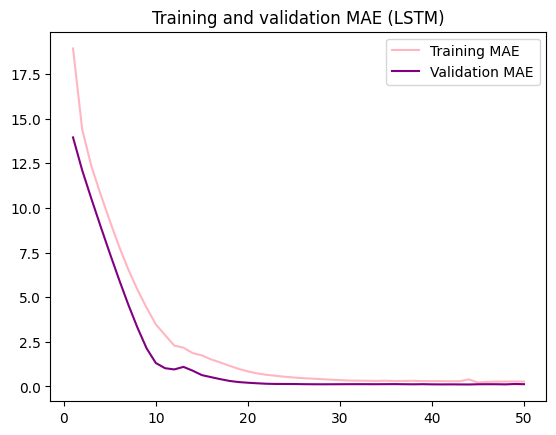

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
MAE: 0.5801
MSE: 0.8608
RMSE: 0.9278


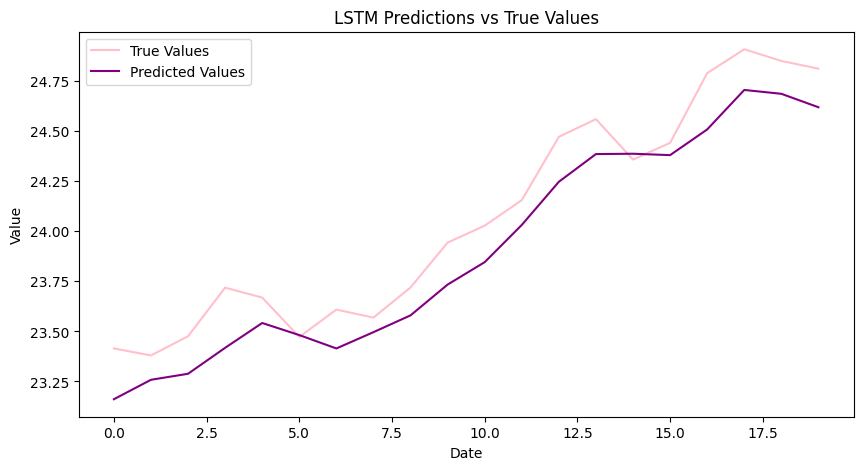

In [88]:
builder.graph_history(hist_stack1_1)
y_trueS,predictionsS = builder.predict(model_stack1_1)
builder.calculate_metrics(y_trueS, predictionsS)
builder.graph_prediction(y_trueS,predictionsS)

In [56]:
model_stack1_2, hist_stack1_2 = builder.create_stacked_GRU(num_l1=128, num_l2=32, epochs=50,
                                                     name_model="Stacked_GRU1_2_128_32")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 348.6233 - mae: 18.3753 - val_loss: 206.4347 - val_mae: 14.3167
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 231.5856 - mae: 14.7057 - val_loss: 162.4890 - val_mae: 12.6895
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 182.1771 - mae: 12.9208 - val_loss: 124.9824 - val_mae: 11.1138
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 144.1478 - mae: 11.3577 - val_loss: 92.9816 - val_mae: 9.5664
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 111.4983 - mae: 9.8462 - val_loss: 66.2018 - val_mae: 8.0459
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 84.0619 - mae: 8.4012 - val_loss: 44.5336 - val_mae: 6.5626
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 61.7427 - mae: 7.0516 - val_loss: 27.8346 - val_mae: 5.1351
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 44.3929 - mae: 5.8528 - val_loss: 15.8513 - val_mae: 3.7929
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━

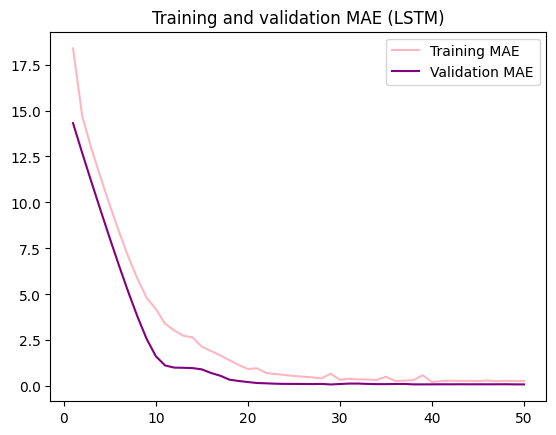

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MAE: 0.5976
MSE: 0.9381
RMSE: 0.9686


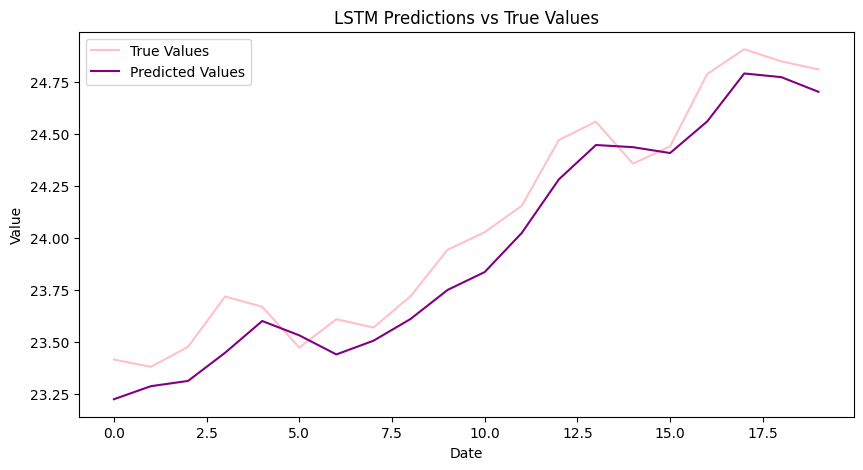

In [89]:
builder.graph_history(hist_stack1_2)
y_trueS,predictionsS = builder.predict(model_stack1_2)
builder.calculate_metrics(y_trueS, predictionsS)
builder.graph_prediction(y_trueS,predictionsS)

In [58]:
model_stack1_3, hist_stack1_3 = builder.create_stacked_GRU(num_l1=128, num_l2=64, epochs=50,
                                                     name_model="Stacked_GRU1_3_128_64")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 226.1463 - mae: 14.1779 - val_loss: 72.6375 - val_mae: 8.4362
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 81.1408 - mae: 8.1698 - val_loss: 32.2649 - val_mae: 5.5497
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 43.1118 - mae: 5.7124 - val_loss: 10.6029 - val_mae: 3.0228
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 22.3096 - mae: 3.8173 - val_loss: 2.4681 - val_mae: 1.2845
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 12.3454 - mae: 2.6005 - val_loss: 1.0943 - val_mae: 0.8623
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 9.7005 - mae: 2.1290 - val_loss: 0.6803 - val_mae: 0.6656
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.3786 - mae: 1.5957 - val_loss: 0.4143 - val_mae: 0.5272
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.5844 - mae: 1.4206 - val_loss: 0.2371 - val_mae: 0.3744
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - l

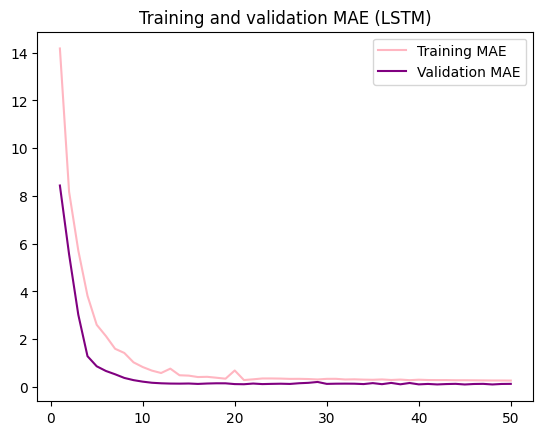

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 0.5386
MSE: 0.6842
RMSE: 0.8272


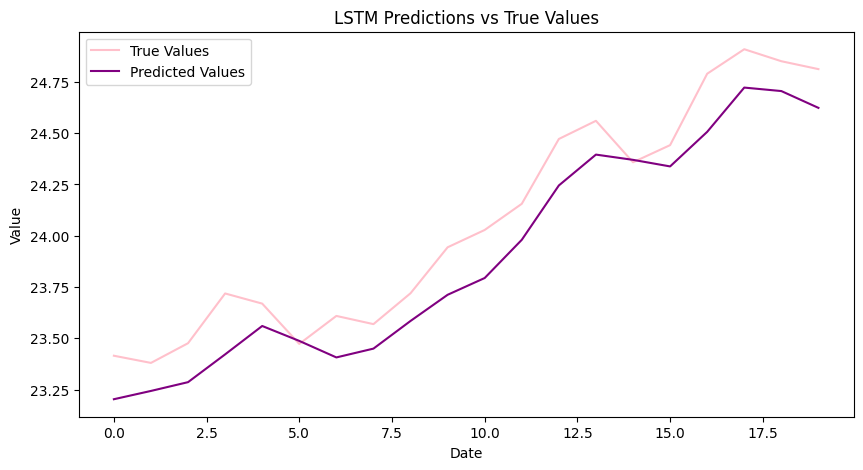

In [90]:
builder.graph_history(hist_stack1_3)
y_trueS,predictionsS = builder.predict(model_stack1_3)
builder.calculate_metrics(y_trueS, predictionsS)
builder.graph_prediction(y_trueS,predictionsS)

In [103]:
model_stack1_4, hist_stack1_4 = builder.create_stacked_GRU(num_l1=128, num_l2=64, epochs=50,
                                                     name_model="Stacked_GRU1_4_128_64")

Epoch 1/50


C:\Users\lenovo\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 239.0090 - mae: 14.5608 - val_loss: 96.2977 - val_mae: 9.7381
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 109.7955 - mae: 9.5559 - val_loss: 47.8984 - val_mae: 6.8142
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 57.4668 - mae: 6.7200 - val_loss: 18.6151 - val_mae: 4.1412
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 37.8412 - mae: 4.9775 - val_loss: 5.0625 - val_mae: 1.9417
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 17.6639 - mae: 3.3108 - val_loss: 1.5175 - val_mae: 1.0252
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 10.4294 - mae: 2.3470 - val_loss: 1.1451 - val_mae: 0.8622
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.0230 - mae: 2.0779 - val_loss: 0.8873 - val_mae: 0.7657
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.0716 - mae: 1.8203 - val_loss: 0.6634 - val_mae: 0.6585
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.36

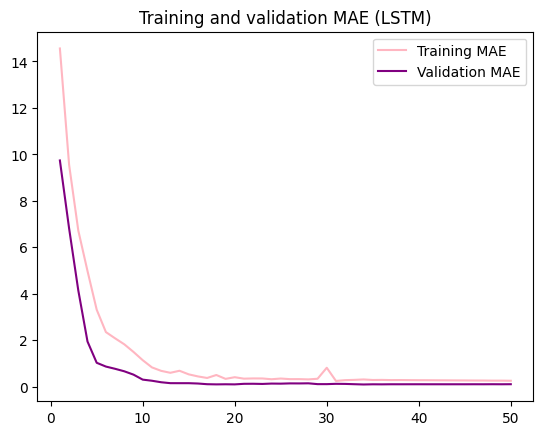

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MAE: 0.5418
MSE: 0.6855
RMSE: 0.8280


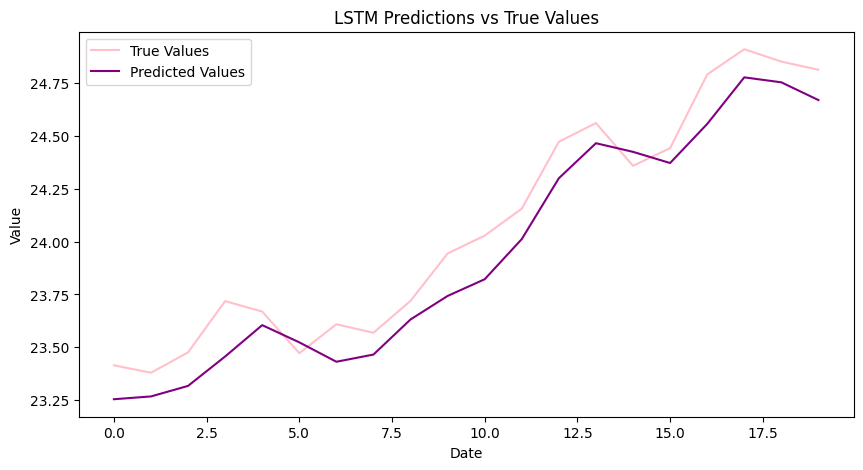

In [104]:
builder.graph_history(hist_stack1_4)
y_trueS,predictionsS = builder.predict(model_stack1_4)
builder.calculate_metrics(y_trueS, predictionsS)
builder.graph_prediction(y_trueS,predictionsS)

In [60]:
model_stack2_1, hist_stack2_1 = builder2.create_stacked_GRU(num_l1=64, num_l2=32, epochs=100,
                                                     name_model="Stacked_GRU2_1_64_32")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 495.1280 - mae: 22.0225 - val_loss: 334.7268 - val_mae: 18.2247
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 279.0354 - mae: 16.3078 - val_loss: 178.0321 - val_mae: 13.2872
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 214.7940 - mae: 14.1712 - val_loss: 154.5133 - val_mae: 12.3705
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 184.2250 - mae: 13.0167 - val_loss: 135.0108 - val_mae: 11.5554
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 163.8495 - mae: 12.2085 - val_loss: 117.3810 - val_mae: 10.7656
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 145.2835 - mae: 11.4245 - val_loss: 101.2696 - val_mae: 9.9893
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 128.1967 - mae: 10.6557 - val_loss: 86.5353 - val_mae: 9.2224
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 112.4739 - mae: 9.9087 - val_loss: 73.1154 - val_mae: 8.4636
Epoch 9/100
25

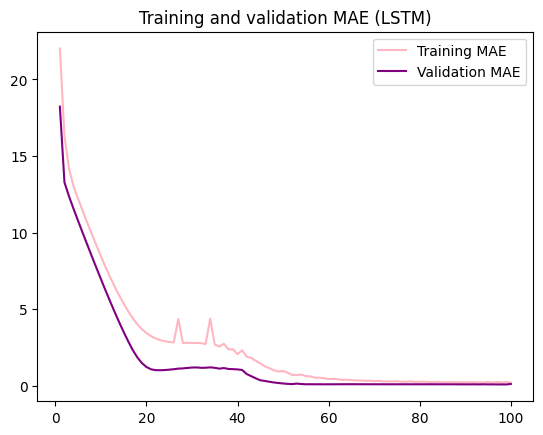

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MAE: 0.4622
MSE: 0.4935
RMSE: 0.7025


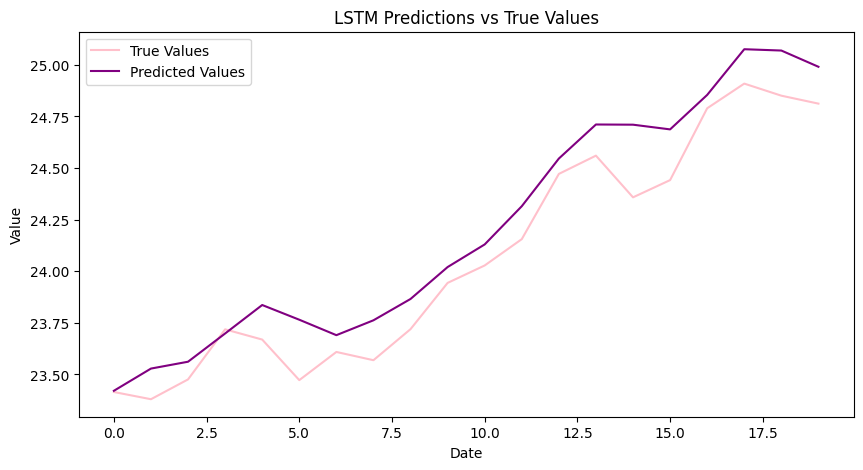

In [91]:
builder2.graph_history(hist_stack2_1)
y_trueS,predictionsS = builder2.predict(model_stack2_1)
builder2.calculate_metrics(y_trueS, predictionsS)
builder2.graph_prediction(y_trueS,predictionsS)

In [62]:
model_stack2_2, hist_stack2_2 = builder2.create_stacked_GRU(num_l1=128, num_l2=32, epochs=100,
                                                     name_model="Stacked_GRU2_2_128_32")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 385.8947 - mae: 19.2299 - val_loss: 206.3523 - val_mae: 14.3131
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 250.4436 - mae: 15.2827 - val_loss: 181.0146 - val_mae: 13.3989
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 228.9442 - mae: 14.3895 - val_loss: 160.0379 - val_mae: 12.5918
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 190.1967 - mae: 13.2434 - val_loss: 140.6384 - val_mae: 11.7964
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 169.8988 - mae: 12.4542 - val_loss: 122.8097 - val_mae: 11.0148
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 151.0824 - mae: 11.6750 - val_loss: 106.3574 - val_mae: 10.2408
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 133.6284 - mae: 10.9054 - val_loss: 91.2256 - val_mae: 9.4732
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 117.4966 - mae: 10.1513 - val_loss: 77.3910 - val_mae: 8.7125
Epoch 9/100


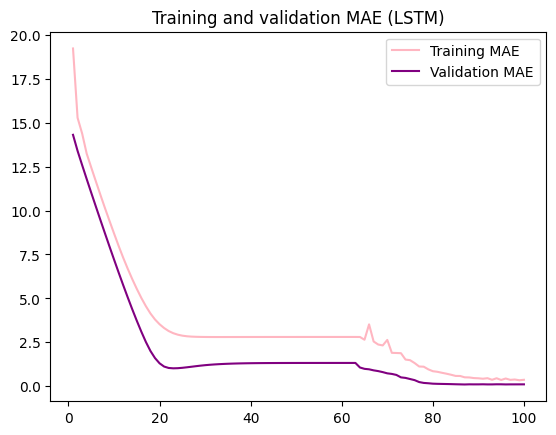

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.9210
MSE: 2.3199
RMSE: 1.5231


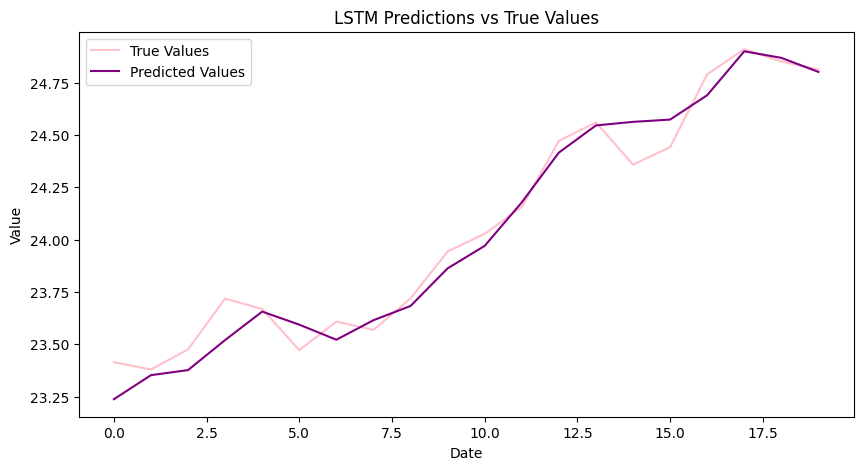

In [92]:
builder2.graph_history(hist_stack2_2)
y_trueS,predictionsS = builder2.predict(model_stack2_2)
builder2.calculate_metrics(y_trueS, predictionsS)
builder2.graph_prediction(y_trueS,predictionsS)

In [64]:
model_stack2_3, hist_stack2_3 = builder2.create_stacked_GRU(num_l1=128, num_l2=64, epochs=100,
                                                     name_model="Stacked_GRU2_3_128_64")

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 343.7786 - mae: 17.8659 - val_loss: 134.2700 - val_mae: 11.5232
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 177.1064 - mae: 12.5754 - val_loss: 100.4304 - val_mae: 9.9471
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 125.3886 - mae: 10.4744 - val_loss: 72.4201 - val_mae: 8.4224
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 92.8955 - mae: 8.8814 - val_loss: 50.1820 - val_mae: 6.9784
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 69.2257 - mae: 7.5110 - val_loss: 32.7885 - val_mae: 5.5951
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 50.6791 - mae: 6.2945 - val_loss: 19.8853 - val_mae: 4.2898
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 36.9048 - mae: 5.2404 - val_loss: 11.0155 - val_mae: 3.0874
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 27.2668 - mae: 4.3606 - val_loss: 5.5868 - val_mae: 2.0521
Epoch 9/100
25/25 ━━━━━━━━━━━━━━

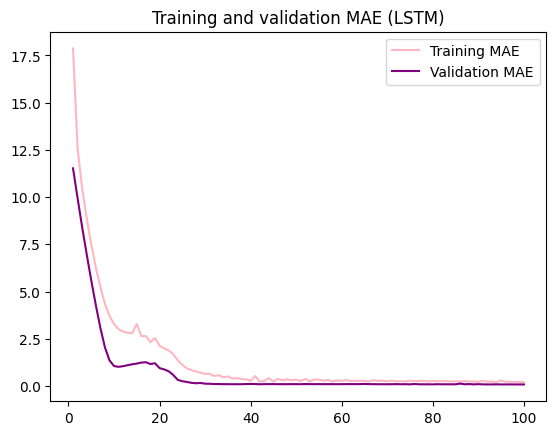

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 0.3644
MSE: 0.3476
RMSE: 0.5896


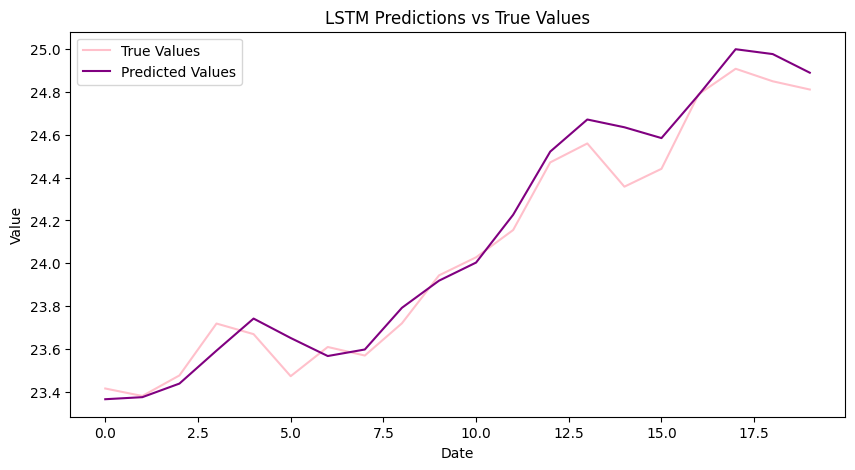

In [93]:
builder2.graph_history(hist_stack2_3)
y_trueS,predictionsS = builder2.predict(model_stack2_3)
builder2.calculate_metrics(y_trueS, predictionsS)
builder2.graph_prediction(y_trueS,predictionsS)

In [66]:
model_stack3_1, hist_stack3_1 = builder3.create_stacked_GRU(num_l1=64, num_l2=32, epochs=150,
                                                     name_model="Stacked_GRU3_1_64_32")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 526.6900 - mae: 22.6938 - val_loss: 452.6624 - val_mae: 21.2351
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 473.7023 - mae: 21.5326 - val_loss: 371.2122 - val_mae: 19.1947
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 334.8558 - mae: 17.9308 - val_loss: 222.9181 - val_mae: 14.8794
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 264.9237 - mae: 15.8669 - val_loss: 203.1432 - val_mae: 14.1992
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 241.7559 - mae: 15.0722 - val_loss: 190.1861 - val_mae: 13.7354
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 227.9706 - mae: 14.6019 - val_loss: 179.0613 - val_mae: 13.3242
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 216.2480 - mae: 14.1954 - val_loss: 168.6839 - val_mae: 12.9290
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 205.2396 - mae: 13.8026 - val_loss: 158.8316 - val_mae: 12.5422
Epoch 9

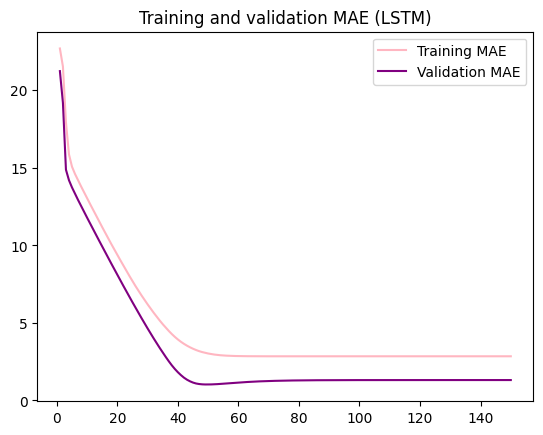

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE: 4.1105
MSE: 27.3072
RMSE: 5.2256


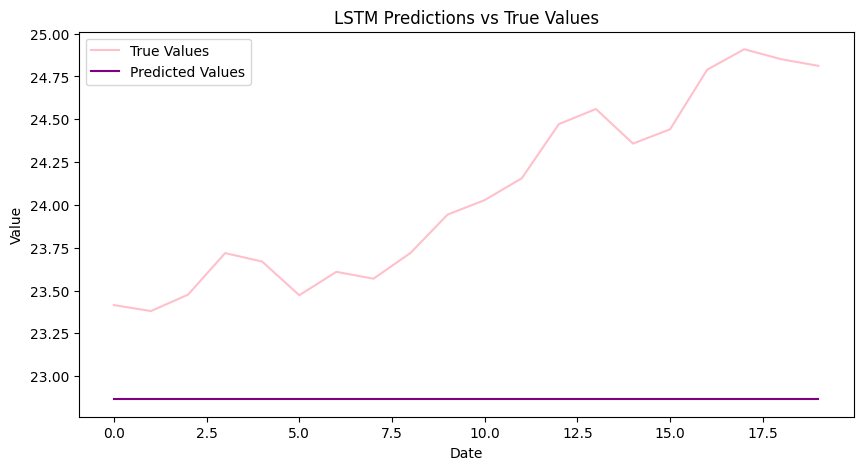

In [94]:
builder3.graph_history(hist_stack3_1)
y_trueS,predictionsS = builder3.predict(model_stack3_1)
builder3.calculate_metrics(y_trueS, predictionsS)
builder3.graph_prediction(y_trueS,predictionsS)

In [68]:
model_stack3_2, hist_stack3_2 = builder3.create_stacked_GRU(num_l1=128, num_l2=32, epochs=150,
                                                     name_model="Stacked_GRU3_2_128_32")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 525.0718 - mae: 22.6600 - val_loss: 424.4662 - val_mae: 20.5580
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 328.8310 - mae: 17.6788 - val_loss: 190.2684 - val_mae: 13.7383
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - loss: 227.8666 - mae: 14.6134 - val_loss: 174.8581 - val_mae: 13.1656
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 211.3350 - mae: 14.0198 - val_loss: 163.9079 - val_mae: 12.7429
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 200.0210 - mae: 13.6117 - val_loss: 154.0142 - val_mae: 12.3486
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - loss: 189.5556 - mae: 13.2222 - val_loss: 144.6848 - val_mae: 11.9649
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 179.6010 - mae: 12.8405 - val_loss: 135.7683 - val_mae: 11.5863
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 170.0432 - mae: 12.4629 - val_loss: 127.2068 - val_mae: 11.2107


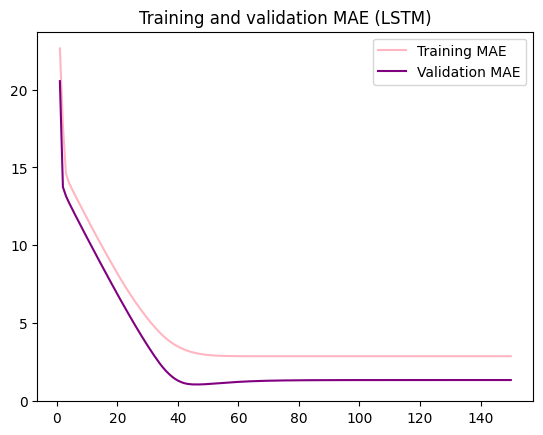

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
MAE: 4.1105
MSE: 27.3072
RMSE: 5.2256


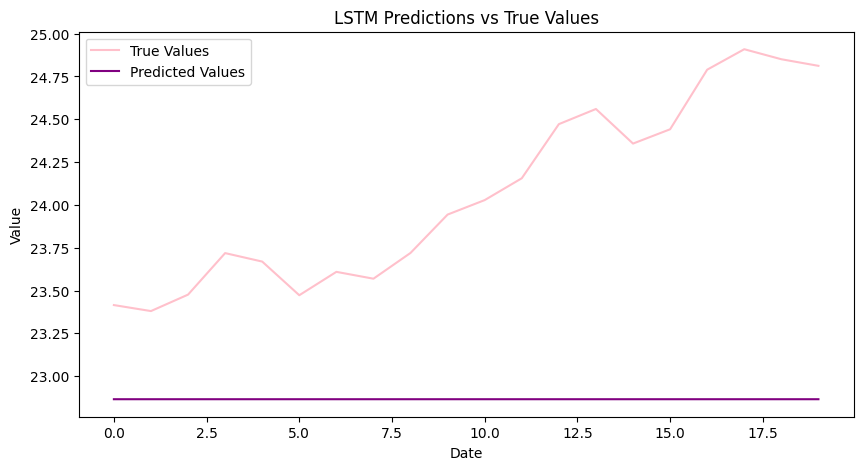

In [95]:
builder3.graph_history(hist_stack3_2)
y_trueS,predictionsS = builder3.predict(model_stack3_2)
builder3.calculate_metrics(y_trueS, predictionsS)
builder3.graph_prediction(y_trueS,predictionsS)

In [70]:
model_stack3_3, hist_stack3_3 = builder3.create_stacked_GRU(num_l1=128, num_l2=64, epochs=150,
                                                     name_model="Stacked_GRU3_3_128_64")

Epoch 1/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 514.3618 - mae: 22.4294 - val_loss: 312.5356 - val_mae: 17.4780
Epoch 2/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 260.5987 - mae: 15.6520 - val_loss: 137.4547 - val_mae: 11.6589
Epoch 3/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - loss: 185.6023 - mae: 13.0156 - val_loss: 114.2487 - val_mae: 10.6171
Epoch 4/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - loss: 142.0760 - mae: 11.2694 - val_loss: 96.9412 - val_mae: 9.7681
Epoch 5/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 124.5009 - mae: 10.4674 - val_loss: 82.9122 - val_mae: 9.0214
Epoch 6/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 109.6609 - mae: 9.7558 - val_loss: 70.4994 - val_mae: 8.3050
Epoch 7/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 96.3229 - mae: 9.0752 - val_loss: 59.3769 - val_mae: 7.6060
Epoch 8/150
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 84.2630 - mae: 8.4129 - val_loss: 49.4317 - val_mae: 6.9214
Epoch 9/150
12/

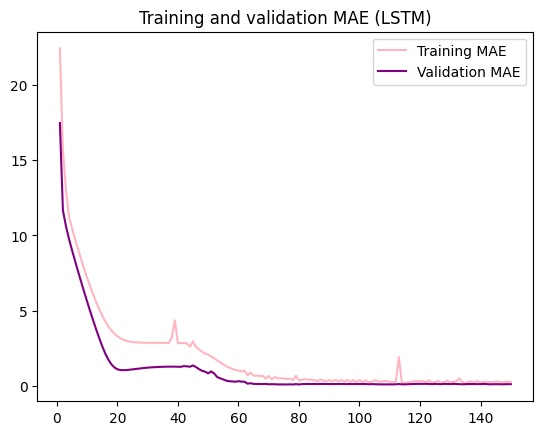

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
MAE: 0.4224
MSE: 4.8707
RMSE: 2.2070


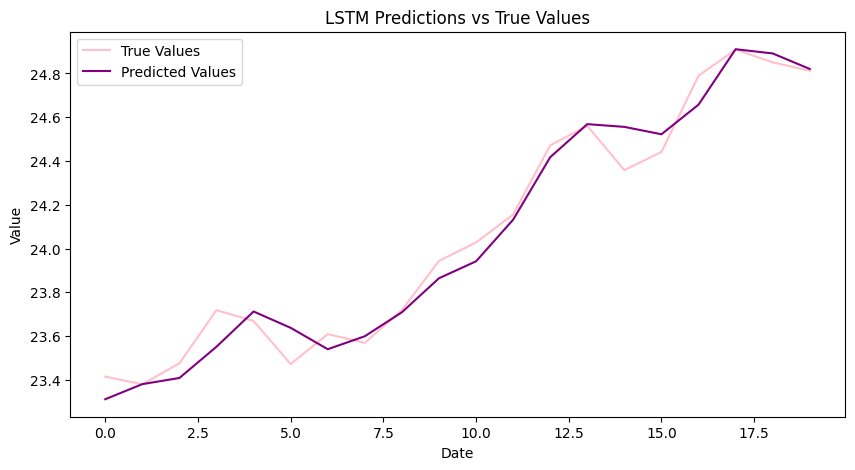

In [96]:
builder3.graph_history(hist_stack3_3)
y_trueS,predictionsS = builder3.predict(model_stack3_3)
builder3.calculate_metrics(y_trueS, predictionsS)
builder3.graph_prediction(y_trueS,predictionsS)